In [1]:
import uproot
import numpy as np
import pandas as pd

In [2]:
input_file = "/Users/ploskon/devel/jewel_project/eventfiles/PbPb_lund_200GeV.root"
# input_file = "/Users/ploskon/devel/jewel_project/eventfiles/pp_lund_200GeV.root"

In [3]:
df_events = uproot.open(input_file)["event_info"].arrays(library="pd")
df_tracks = uproot.open(input_file)["tracks"].arrays(library="pd")

In [4]:
df_events.head()

eventID        weight        xsec
0      0.0  2.172660e-13  357.460999
1      1.0  1.992140e-12  341.791992
2      2.0  8.453220e-13  510.057007
3      3.0  4.162010e-13  404.201996
4      4.0  1.784940e-12  410.167999

In [5]:
df_tracks.head()

eventID   label        px        py          pz      energy
0      0.0   211.0  0.111455 -0.161925 -117.398003  117.398003
1      0.0    22.0 -0.000144 -0.070827   57.999500   57.999500
2      0.0    22.0  0.054620  0.037013  126.836998  126.836998
3      0.0 -2112.0 -0.011232 -0.047440    1.111823    1.112892
4      0.0  3122.0  0.001742  0.174470    1.335099    1.346452

In [6]:
import yasp

import heppyy.util.fastjet_cppyy
import heppyy.util.pythia8_cppyy
import heppyy.util.heppyy_cppyy

from cppyy.gbl import fastjet as fj
from cppyy.gbl.std import vector

from yasp import GenericObject
import math

# make a singleton class for JetAlgoHelper
class JetAlgoHelper(object):
	_instance = None

	@staticmethod
	def get_instance():
		if JetAlgoHelper._instance is None:
			JetAlgoHelper()
		return JetAlgoHelper._instance

	def __init__(self):
		if JetAlgoHelper._instance is not None:
			raise Exception("This class is a singleton!")
		else:
			JetAlgoHelper._instance = self
			self.jet_def_wta = fj.JetDefinition(fj.cambridge_algorithm, 1.0)
			self.jet_def_wta.set_recombination_scheme(fj.WTA_pt_scheme)
			self.reclusterer_wta 	= fj.contrib.Recluster(self.jet_def_wta)
			self.sd01 = fj.contrib.SoftDrop(0, 0.1, 1.0)
			self.sd02 = fj.contrib.SoftDrop(0, 0.2, 1.0)
			self.lund_gen = fj.contrib.LundGenerator()
			print('[i] creating LundGenerator:', self.lund_gen)

	@classmethod
	def angularity(self, jet, a, k, jetR):
		ang = 0.0
		for p in jet.constituents():
			dr = jet.delta_R(p) / jetR
			pt = p.perp() / jet.perp()
			ang += ((dr)**a) * ((pt)**k)
		return ang

	def mass(self, jet):
		m2 = jet.e()**2 - jet.px()**2 - jet.py()**2 - jet.pz()**2
		if m2 > 0:
			return math.sqrt(m2)
		return 0.0

	def lund_delta_kt(self, jet):
		return [[l.Delta(), l.kt()] for l in self.lund_gen.result(jet)]

	def lund_log(self, jet):
		return [[math.log(1./l.Delta()), math.log(l.kt())] for l in self.lund_gen.result(jet)]

	def lunds_dict_list(self, jet):
		lunds = []
		for i, l in enumerate(self.lund_gen.result(jet)):
			lunds.append({'i': i, 'pt': l.pair().perp(), 
                 		'pt1': l.harder().perp(), 'pt2': l.softer().perp(), 'eta': l.pair().eta(), 
                   	'kt': l.kt(), 'delta': l.Delta(), 'kappa': l.kappa(), 'psi': l.psi(), 'z': l.z(), 'm': l.m()})
		return lunds

class LundJet(GenericObject):
	def __init__(self, jet, jetR, label=None, **kwargs):
		super().__init__(**kwargs)
		self.jet = jet
		self.pt = jet.pt()
		self.eta = jet.eta()
		self.y = jet.rap()
		self.phi = jet.phi()
		self.e = jet.e()
		self.m = jet.m()
		self.nconst = jet.constituents().size()
		self.jetR = jetR
		self.label = label

		self._jalgo = JetAlgoHelper.get_instance()

		self.jet_wta 	= self._jalgo.reclusterer_wta.result(jet)
		self.jet_sd01 = self._jalgo.sd01.result(jet)
		self.jet_sd02 = self._jalgo.sd02.result(jet)
		self.wtastd 	= self.jet_wta.delta_R(jet)
		self.wtasd01 	= self.jet_sd01.delta_R(jet)
		self.wtasd02 	= self.jet_sd02.delta_R(jet)
		self.angk1a1 	= self._jalgo.angularity(jet, 1.0, 1.0, self.jetR)
		self.angk1a2 	= self._jalgo.angularity(jet, 2.0, 1.0, self.jetR)
		self.angk1a3 	= self._jalgo.angularity(jet, 3.0, 1.0, self.jetR)
		self.mjet 		= self._jalgo.mass(jet)
		# self.lund_delta_kt = self._jalgo.lund_delta_kt(jet)
		# self.lund_log = self._jalgo.lund_log(jet)
		self.lunds = self._jalgo.lunds_dict_list(jet)

		self._base_props_list = []
		self._base_props_list = self._gen_base_props_list()

	def _gen_base_props_list(self):
		_g0 = GenericObject()
		l = [a for a in _g0.__dict__]
		_ = [l.append(a) for a in self.__dict__ if a[0] == '_' and a not in l]
		return l

	def to_dict(self):
		# Convert the object to a dictionary
		d = {}
		for key in self.__dict__:
			if key not in self._base_props_list:
				d[key] = getattr(self, key)
		return d

	def to_basic_type_dict(self):
		# Convert the object to a dictionary
		d = {}
		for key in self.__dict__:
			if key not in self._base_props_list:
				o = getattr(self, key)
				if isinstance(o, fj.PseudoJet):
					d[key] = [o.px(), o.py(), o.pz(), o.e()]
				else:
					d[key] = getattr(self, key)
		return d

/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/loader.py:90: UserWarning: No precompiled header available (/Users/ploskon/devel/yasp/software/bundle/hepbase/root/default/lib/cppyy_backend/etc not writable); this may impact performance.
  warnings.warn('No precompiled header available (%s); this may impact performance.' % msg)
[yasp-i] Running in Jupyter: True


In [7]:
def lund_jets(df, include_groups=True, label=''):
  jets_dicts = []
  parts = vector[fj.PseudoJet]([fj.PseudoJet(p.px, p.py, p.pz, p.energy) for p in df.itertuples()])
  jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
  cluster_seq = fj.ClusterSequence(parts, jet_def)
  jets = fj.sorted_by_pt(cluster_seq.inclusive_jets())
  
  for j in jets:
    jet = LundJet(jet=j, jetR=0.4, label=label)
    jets_dicts.append(jet.to_basic_type_dict())
  
  return pd.DataFrame(jets_dicts)

In [8]:
df_lunds = pd.merge(df_events, df_tracks, on="eventID").groupby("eventID").apply(lund_jets, include_groups=False, label='PbPb').reset_index(drop=True)
df_lunds.to_parquet('saved_lunds.parquet', engine="pyarrow")

#--------------------------------------------------------------------------
#                         FastJet release 3.5.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           https://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
[i] creating LundGenerator: @0x340232850
#----------------------------------

In [9]:
!ls -ltr *.parquet

-rw-r--r--@ 1 ploskon  staff      19033 May 14 18:32 jets.parquet
-rw-r--r--@ 1 ploskon  staff   14620522 May 16 19:18 pythia_lund_jet_unlabelled.parquet
-rw-r--r--@ 1 ploskon  staff   15039365 May 19 14:22 lund_jet_hardQCDbeauty.parquet
-rw-r--r--@ 1 ploskon  staff   14961016 May 19 14:22 lund_jet_hardQCDcharm.parquet
-rw-r--r--@ 1 ploskon  staff   14231883 May 19 14:23 lund_jet_hardQCDquarks.parquet
-rw-r--r--@ 1 ploskon  staff   14621070 May 19 14:23 lund_jet_hardQCDany.parquet
-rw-r--r--@ 1 ploskon  staff   14711110 May 19 14:23 lund_jet_hardQCDlf.parquet
-rw-r--r--@ 1 ploskon  staff   14815345 May 19 14:23 lund_jet_hardQCDgluons.parquet
-rw-r--r--@ 1 ploskon  staff      28018 May 20 16:16 pythia_lund_jet.parquet
-rw-r--r--@ 1 ploskon  staff      29788 May 20 16:16 pythia_lund_jet_emb.parquet
-rw-r--r--@ 1 ploskon  staff  309046093 Jul 24 14:40 saved_lunds.parquet


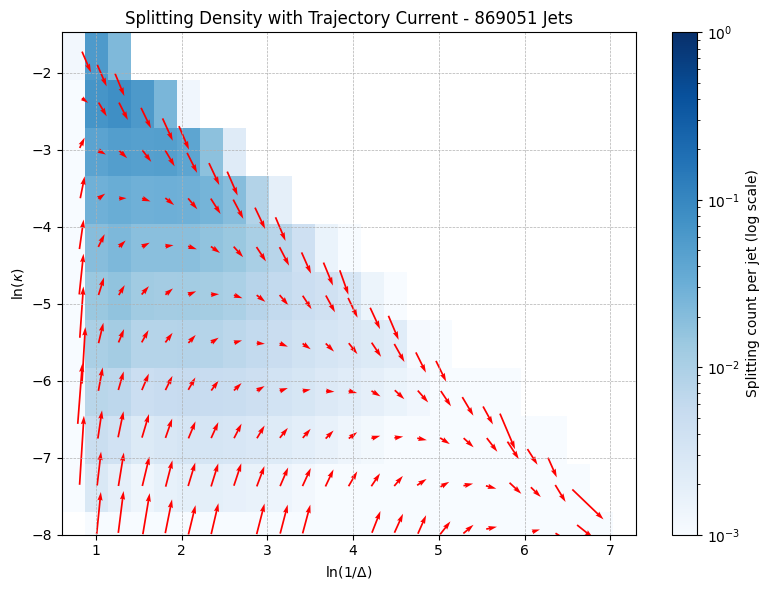

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

s_kt_or_kappa = 'kt'
s_kt_or_kappa = 'kappa'

# Extract lund records from all jets
records = []
for _, row in df_jets.iterrows():
    lunds = row['lunds']
    for i in range(len(lunds) - 1):
        kt_i, delta_i = lunds[i][s_kt_or_kappa], lunds[i]['delta']
        kt_j, delta_j = lunds[i+1][s_kt_or_kappa], lunds[i+1]['delta']
        x_i, y_i = np.log(1/delta_i), np.log(kt_i)
        x_j, y_j = np.log(1/delta_j), np.log(kt_j)
        records.append({'x': x_i, 'y': y_i, 'dx': x_j - x_i, 'dy': y_j - y_i})

df = pd.DataFrame(records)

# Define grid and bin the (x,y) positions
nx, ny = 25, 25
x_bins = np.linspace(df['x'].min(), df['x'].max(), nx + 1)
y_bins = np.linspace(df['y'].min(), df['y'].max(), ny + 1)
df['ix'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['iy'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

# Compute average displacement per bin
group = (
    df.groupby(['ix', 'iy'])
      .agg(x=('x', 'mean'), y=('y', 'mean'),
           dx=('dx', 'mean'), dy=('dy', 'mean'))
      .dropna()
      .reset_index()
)

y_limit_low = df['y'].min()
y_limit_low = -8
if s_kt_or_kappa == 'kt':
    # Apply cut for plotting only (ln(kT) > -4)
    y_limit_low = -4

df_plot = df[df['y'] > y_limit_low]
group_plot = group[group['y'] > y_limit_low]

plt.figure(figsize=(8, 6))

# 1) density background (only for ln(kT) > -4)
weights_plot = np.ones_like(df_plot['x']) / len(df_jets)
plt.hist2d(
    df_plot['x'], df_plot['y'],
    bins=[x_bins, y_bins],
    cmap='Blues',
    norm=mcolors.LogNorm(),
    weights=weights_plot
)
plt.clim(0.001, 1.0)
plt.colorbar(label='Splitting count per jet (log scale)')

# 2) trajectory current (quiver only for arrows starting at ln(kT) > -4)
plt.quiver(group_plot['x'], group_plot['y'], group_plot['dx'], group_plot['dy'], 
           angles='xy', scale_units='xy', scale=5, width=0.003, color='red', alpha=1.0)

plt.xlabel(r'$\ln(1/\Delta)$')
ylabel_latex = r'$\ln(k_T)$' if s_kt_or_kappa == 'kt' else r'$\ln(\kappa)$'
plt.ylabel(ylabel_latex)
plt.ylim(y_limit_low, None)
plt.title(f'Splitting Density with Trajectory Current - {len(df_jets)} Jets')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

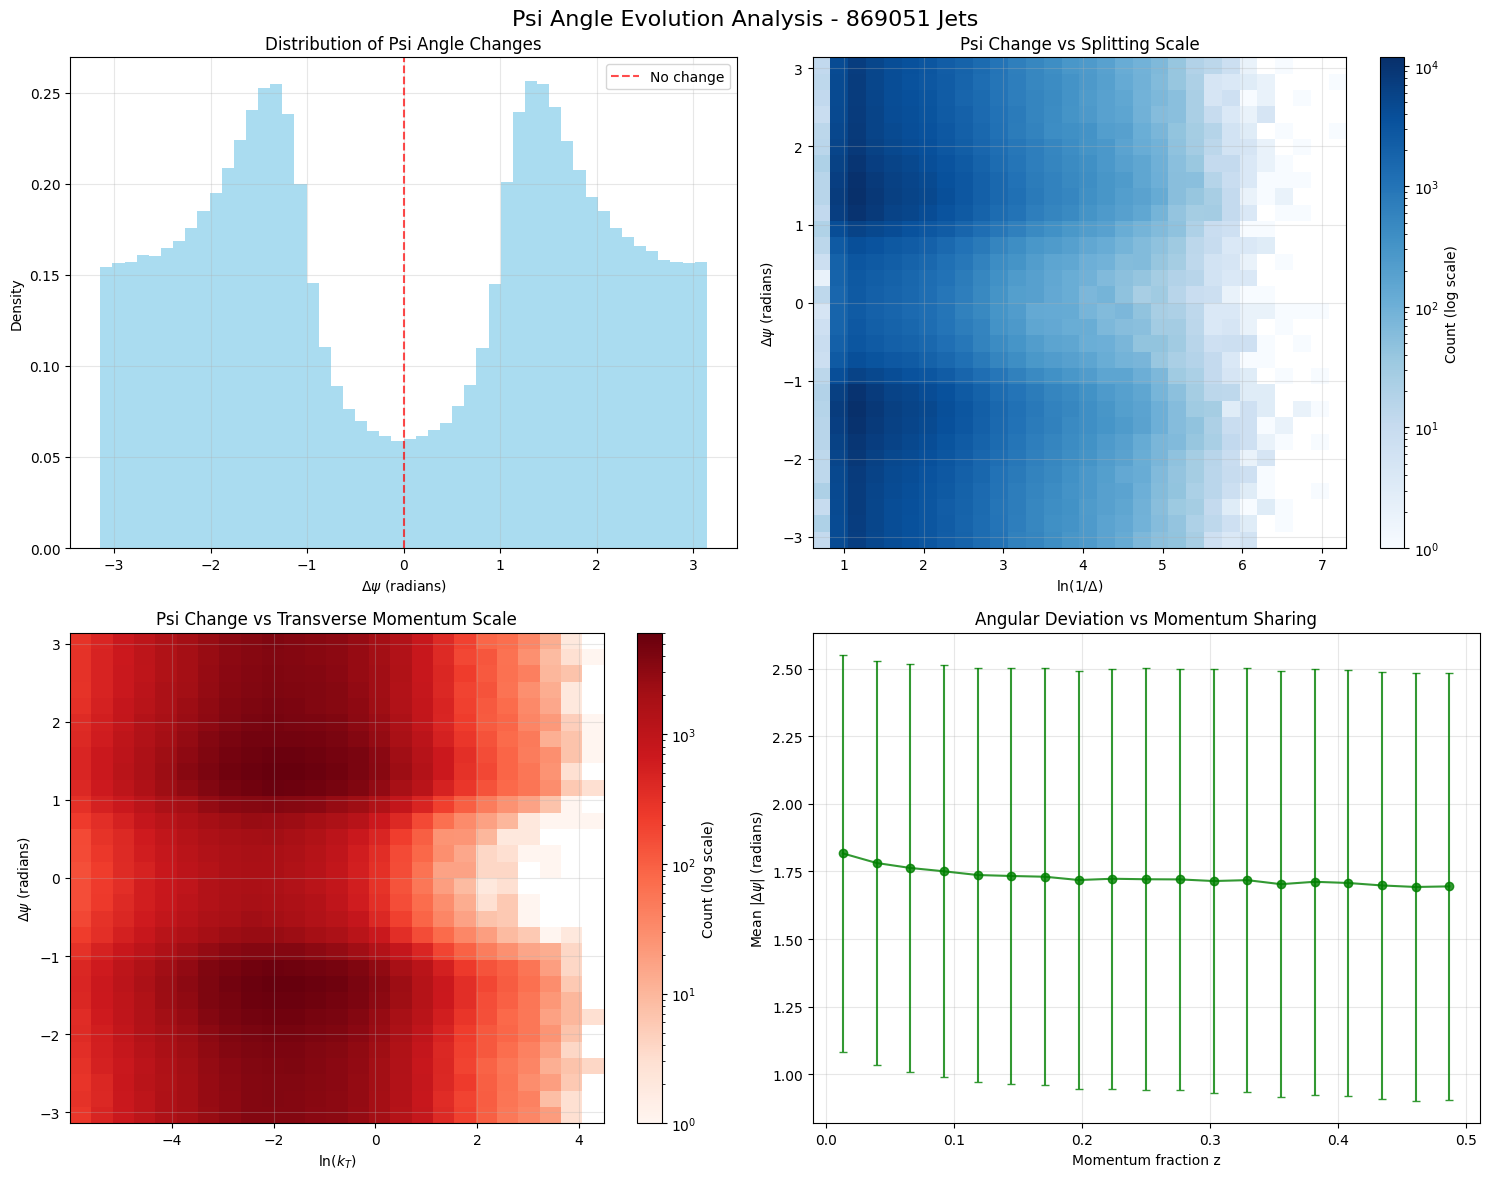

Total number of consecutive splitting pairs: 1124825
Mean |Δψ|: 1.740 radians
Std |Δψ|: 0.769 radians
Fraction with |Δψ| > π/2: 0.561
Fraction with |Δψ| > π/4: 0.888


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

# Extract psi angle changes from all jets
psi_records = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    if len(lunds) < 2:  # Need at least 2 splittings
        continue
    
    for i in range(len(lunds) - 1):
        psi_i = lunds[i]['psi']
        psi_j = lunds[i+1]['psi']
        
        # Calculate psi change, handling periodicity (-pi to pi)
        delta_psi = psi_j - psi_i
        # Wrap to [-pi, pi]
        while delta_psi > np.pi:
            delta_psi -= 2*np.pi
        while delta_psi < -np.pi:
            delta_psi += 2*np.pi
            
        # Also get other splitting properties for context
        kt_i = lunds[i]['kt']
        delta_i = lunds[i]['delta']
        z_i = lunds[i]['z']
        
        psi_records.append({
            'jet_idx': jet_idx,
            'splitting_idx': i,
            'psi_i': psi_i,
            'psi_j': psi_j,
            'delta_psi': delta_psi,
            'ln_kt': np.log(kt_i),
            'ln_inv_delta': np.log(1/delta_i),
            'z': z_i
        })

df_psi = pd.DataFrame(psi_records)

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1) Distribution of psi angle changes
ax1 = axes[0, 0]
ax1.hist(df_psi['delta_psi'], bins=50, alpha=0.7, color='skyblue', density=True)
ax1.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
ax1.set_xlabel(r'$\Delta\psi$ (radians)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution of Psi Angle Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2) Psi change vs ln(1/Delta) - shows angular evolution vs splitting scale
ax2 = axes[0, 1]
# Create 2D histogram for better visualization of dense data
h = ax2.hist2d(df_psi['ln_inv_delta'], df_psi['delta_psi'], 
               bins=[30, 30], cmap='Blues', norm=mcolors.LogNorm())
plt.colorbar(h[3], ax=ax2, label='Count (log scale)')
ax2.set_xlabel(r'$\ln(1/\Delta)$')
ax2.set_ylabel(r'$\Delta\psi$ (radians)')
ax2.set_title('Psi Change vs Splitting Scale')
ax2.grid(True, alpha=0.3)

# 3) Psi change vs ln(kT) - shows angular evolution vs transverse momentum scale
ax3 = axes[1, 0]
# Filter for reasonable kT range to avoid clutter
df_psi_filtered = df_psi[df_psi['ln_kt'] > -6]
h = ax3.hist2d(df_psi_filtered['ln_kt'], df_psi_filtered['delta_psi'], 
               bins=[25, 30], cmap='Reds', norm=mcolors.LogNorm())
plt.colorbar(h[3], ax=ax3, label='Count (log scale)')
ax3.set_xlabel(r'$\ln(k_T)$')
ax3.set_ylabel(r'$\Delta\psi$ (radians)')
ax3.set_title('Psi Change vs Transverse Momentum Scale')
ax3.grid(True, alpha=0.3)

# 4) Psi change vs momentum fraction z
ax4 = axes[1, 1]
# Create bins for z and calculate mean delta_psi in each bin
z_bins = np.linspace(0, 0.5, 20)  # Focus on z < 0.5 (softer splittings)
df_psi_z = df_psi[df_psi['z'] < 0.5]
z_centers = []
delta_psi_means = []
delta_psi_stds = []

for i in range(len(z_bins)-1):
    mask = (df_psi_z['z'] >= z_bins[i]) & (df_psi_z['z'] < z_bins[i+1])
    if mask.sum() > 10:  # Require at least 10 points
        z_centers.append((z_bins[i] + z_bins[i+1]) / 2)
        delta_psi_means.append(df_psi_z[mask]['delta_psi'].abs().mean())
        delta_psi_stds.append(df_psi_z[mask]['delta_psi'].abs().std())

z_centers = np.array(z_centers)
delta_psi_means = np.array(delta_psi_means)
delta_psi_stds = np.array(delta_psi_stds)

ax4.errorbar(z_centers, delta_psi_means, yerr=delta_psi_stds, 
             marker='o', capsize=3, color='green', alpha=0.8)
ax4.set_xlabel('Momentum fraction z')
ax4.set_ylabel(r'Mean $|\Delta\psi|$ (radians)')
ax4.set_title('Angular Deviation vs Momentum Sharing')
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Psi Angle Evolution Analysis - {len(df_jets)} Jets', fontsize=16)
plt.tight_layout()
plt.show()

# Print some statistics
print(f"Total number of consecutive splitting pairs: {len(df_psi)}")
print(f"Mean |Δψ|: {df_psi['delta_psi'].abs().mean():.3f} radians")
print(f"Std |Δψ|: {df_psi['delta_psi'].abs().std():.3f} radians")
print(f"Fraction with |Δψ| > π/2: {(df_psi['delta_psi'].abs() > np.pi/2).mean():.3f}")
print(f"Fraction with |Δψ| > π/4: {(df_psi['delta_psi'].abs() > np.pi/4).mean():.3f}")

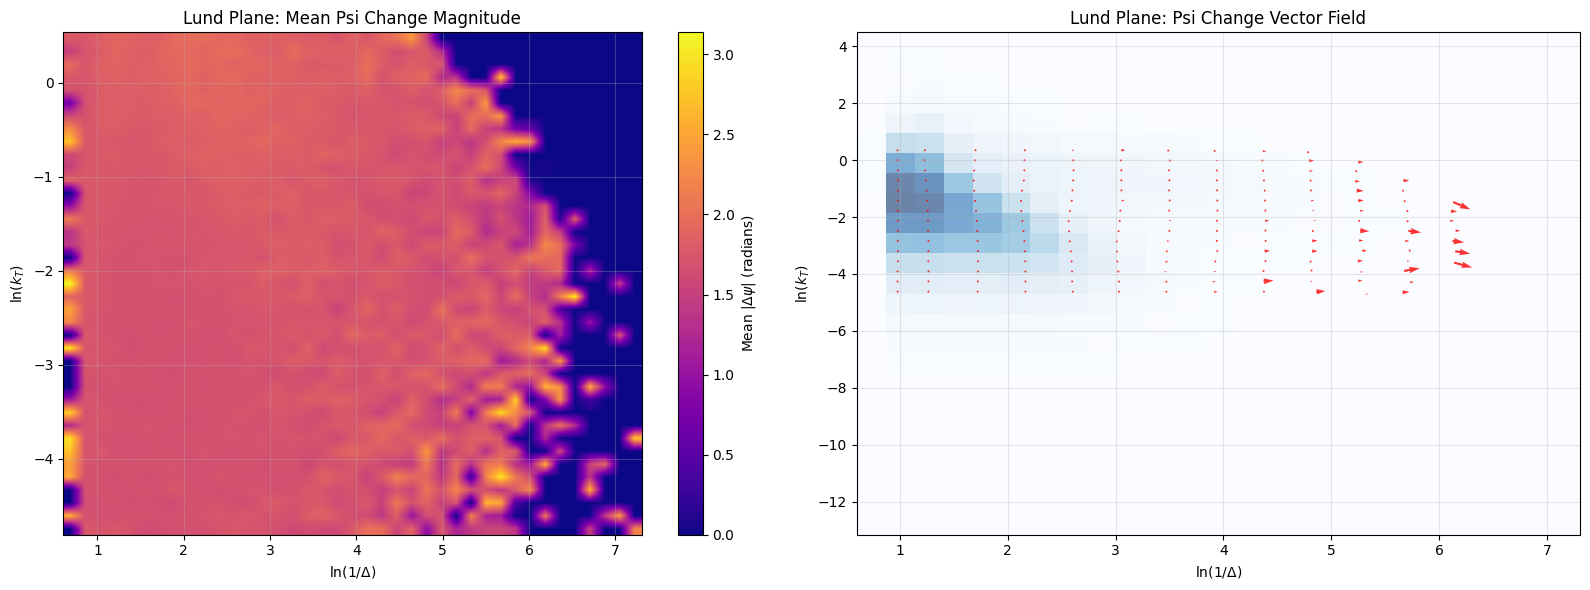


Correlation Analysis:
  |Δψ| vs z: 0.000
  |Δψ| vs ln_inv_delta: 0.000
  |Δψ| vs ln_kt: 0.000

Jet-by-jet psi evolution (first 5 jets):
  Jet 0: ψ = ['2.20', '-1.27', '2.14', '-1.81', '1.15', '-3.07', '0.20', '1.72', '-3.05']
            Δψ = ['2.82', '-2.87', '2.33', '2.95', '2.07', '-3.01', '1.51', '1.51']
  Jet 1: ψ = ['-1.71', '0.28', '1.44', '2.62', '-2.32', '2.00', '-1.03', '1.50', '-2.04', '2.93', '1.99', '-1.55', '0.18', '1.31']
            Δψ = ['1.98', '1.17', '1.18', '1.35', '-1.97', '-3.03', '2.52', '2.75', '-1.32', '-0.94', '2.74', '1.72', '1.13']
  Jet 2: ψ = ['0.64', '3.03', '-1.83', '-0.22', '1.07', '0.04', '-1.57', '2.59', '0.64', '-0.39']
            Δψ = ['2.39', '1.42', '1.61', '1.30', '-1.04', '-1.60', '-2.13', '-1.95', '-1.03']
  Jet 3: ψ = ['-2.57', '2.30', '0.40', '-0.44', '0.57']
            Δψ = ['-1.41', '-1.90', '-0.84', '1.01']
  Jet 4: ψ = ['-0.71', '0.93', '2.92', '-2.07', '0.01', '-1.07', '-2.27', '-0.35', '-2.55', '0.20']
            Δψ = ['1.64', '1.9

In [12]:
# Psi Angle Trajectories in Lund Plane
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Density plot color-coded by psi change magnitude
ax1 = axes[0]
# Create bins for the 2D histogram
x_bins = np.linspace(df_psi['ln_inv_delta'].min(), df_psi['ln_inv_delta'].max(), 40)
y_bins = np.linspace(df_psi['ln_kt'].quantile(0.05), df_psi['ln_kt'].quantile(0.95), 40)

# Create weighted histogram where weights are the psi change magnitude
weights = np.abs(df_psi['delta_psi'])
hist, x_edges, y_edges = np.histogram2d(df_psi['ln_inv_delta'], df_psi['ln_kt'], 
                                       bins=[x_bins, y_bins], weights=weights)
# Normalize by counts to get mean psi change per bin
counts, _, _ = np.histogram2d(df_psi['ln_inv_delta'], df_psi['ln_kt'], 
                             bins=[x_bins, y_bins])
mean_psi_change = np.divide(hist, counts, out=np.zeros_like(hist), where=counts!=0)

# Plot the result
im = ax1.imshow(mean_psi_change.T, origin='lower', aspect='auto', 
                extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
                cmap='plasma', interpolation='bilinear')
plt.colorbar(im, ax=ax1, label=r'Mean $|\Delta\psi|$ (radians)')
ax1.set_xlabel(r'$\ln(1/\Delta)$')
ax1.set_ylabel(r'$\ln(k_T)$')
ax1.set_title('Lund Plane: Mean Psi Change Magnitude')
ax1.grid(True, alpha=0.3)

# 2) Vector field showing psi evolution direction
ax2 = axes[1]

# Create a background density plot first
weights = np.ones_like(df_psi['ln_inv_delta']) / len(df_jets)
ax2.hist2d(df_psi['ln_inv_delta'], df_psi['ln_kt'], 
           bins=[25, 25], cmap='Blues', alpha=0.6, weights=weights)

# Create a vector field based on psi changes
# Bin the data and calculate average psi change direction
nx, ny = 15, 15
x_bins = np.linspace(df_psi['ln_inv_delta'].min(), df_psi['ln_inv_delta'].max(), nx + 1)
y_bins = np.linspace(df_psi['ln_kt'].quantile(0.05), df_psi['ln_kt'].quantile(0.95), ny + 1)

df_psi['ix'] = pd.cut(df_psi['ln_inv_delta'], bins=x_bins, labels=False, include_lowest=True)
df_psi['iy'] = pd.cut(df_psi['ln_kt'], bins=y_bins, labels=False, include_lowest=True)

# Compute average position and psi change per bin
psi_group = (
    df_psi.groupby(['ix', 'iy'])
    .agg(x=('ln_inv_delta', 'mean'), 
         y=('ln_kt', 'mean'),
         delta_psi_mean=('delta_psi', 'mean'),
         delta_psi_std=('delta_psi', 'std'),
         count=('delta_psi', 'count'))
    .dropna()
    .reset_index()
)

# Filter bins with sufficient statistics
psi_group = psi_group[psi_group['count'] >= 5]

# Convert psi change to arrow components (just for visualization direction)
# Scale arrows by the magnitude of average psi change
arrow_scale = 0.3
u = arrow_scale * np.cos(psi_group['delta_psi_mean']) * np.abs(psi_group['delta_psi_mean'])
v = arrow_scale * np.sin(psi_group['delta_psi_mean']) * np.abs(psi_group['delta_psi_mean'])

ax2.quiver(psi_group['x'], psi_group['y'], u, v,
           angles='xy', scale_units='xy', scale=1, 
           width=0.003, color='red', alpha=0.8)

ax2.set_xlabel(r'$\ln(1/\Delta)$')
ax2.set_ylabel(r'$\ln(k_T)$')
ax2.set_title('Lund Plane: Psi Change Vector Field')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional analysis: Correlation between psi changes and other variables
print("\nCorrelation Analysis:")
correlations = df_psi[['delta_psi', 'ln_kt', 'ln_inv_delta', 'z']].corr()['delta_psi'].abs().sort_values(ascending=False)
for var, corr in correlations.items():
    if var != 'delta_psi':
        print(f"  |Δψ| vs {var}: {corr:.3f}")

# Look at psi evolution patterns within individual jets
print(f"\nJet-by-jet psi evolution (first 5 jets):")
for jet_idx in df_psi['jet_idx'].unique()[:5]:
    jet_data = df_psi[df_psi['jet_idx'] == jet_idx].sort_values('splitting_idx')
    if len(jet_data) >= 2:
        psi_sequence = jet_data['psi_i'].tolist() + [jet_data.iloc[-1]['psi_j']]
        delta_psi_sequence = jet_data['delta_psi'].tolist()
        print(f"  Jet {jet_idx}: ψ = {[f'{p:.2f}' for p in psi_sequence]}")
        print(f"            Δψ = {[f'{dp:.2f}' for dp in delta_psi_sequence]}")

In [13]:
# Analysis: Highest kT splitting and its immediate successor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

# Extract highest kT splitting and next splitting pairs
hardest_pairs = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    if len(lunds) < 2:  # Need at least 2 splittings
        continue
    
    # Find the splitting with highest kT
    kt_values = [l['kt'] for l in lunds]
    max_kt_idx = np.argmax(kt_values)
    
    # Check if there's a next splitting after the hardest one
    if max_kt_idx < len(lunds) - 1:
        hardest = lunds[max_kt_idx]
        next_split = lunds[max_kt_idx + 1]
        
        # Calculate psi change
        delta_psi = next_split['psi'] - hardest['psi']
        # Wrap to [-pi, pi]
        while delta_psi > np.pi:
            delta_psi -= 2*np.pi
        while delta_psi < -np.pi:
            delta_psi += 2*np.pi
        
        hardest_pairs.append({
            'jet_idx': jet_idx,
            'hardest_kt': hardest['kt'],
            'hardest_ln_kt': np.log(hardest['kt']),
            'hardest_ln_inv_delta': np.log(1/hardest['delta']),
            'hardest_z': hardest['z'],
            'hardest_psi': hardest['psi'],
            'next_kt': next_split['kt'],
            'next_ln_kt': np.log(next_split['kt']),
            'next_ln_inv_delta': np.log(1/next_split['delta']),
            'next_z': next_split['z'],
            'next_psi': next_split['psi'],
            'delta_psi': delta_psi,
            'kt_ratio': next_split['kt'] / hardest['kt'],
            'delta_ratio': next_split['delta'] / hardest['delta']
        })

df_hardest = pd.DataFrame(hardest_pairs)

print(f"Number of jets with hardest + next splitting pairs: {len(df_hardest)}")
print(f"Mean kT ratio (next/hardest): {df_hardest['kt_ratio'].mean():.3f}")
print(f"Mean |Δψ| for hardest pairs: {df_hardest['delta_psi'].abs().mean():.3f} radians")

Number of jets with hardest + next splitting pairs: 317055
Mean kT ratio (next/hardest): 0.320
Mean |Δψ| for hardest pairs: 1.725 radians


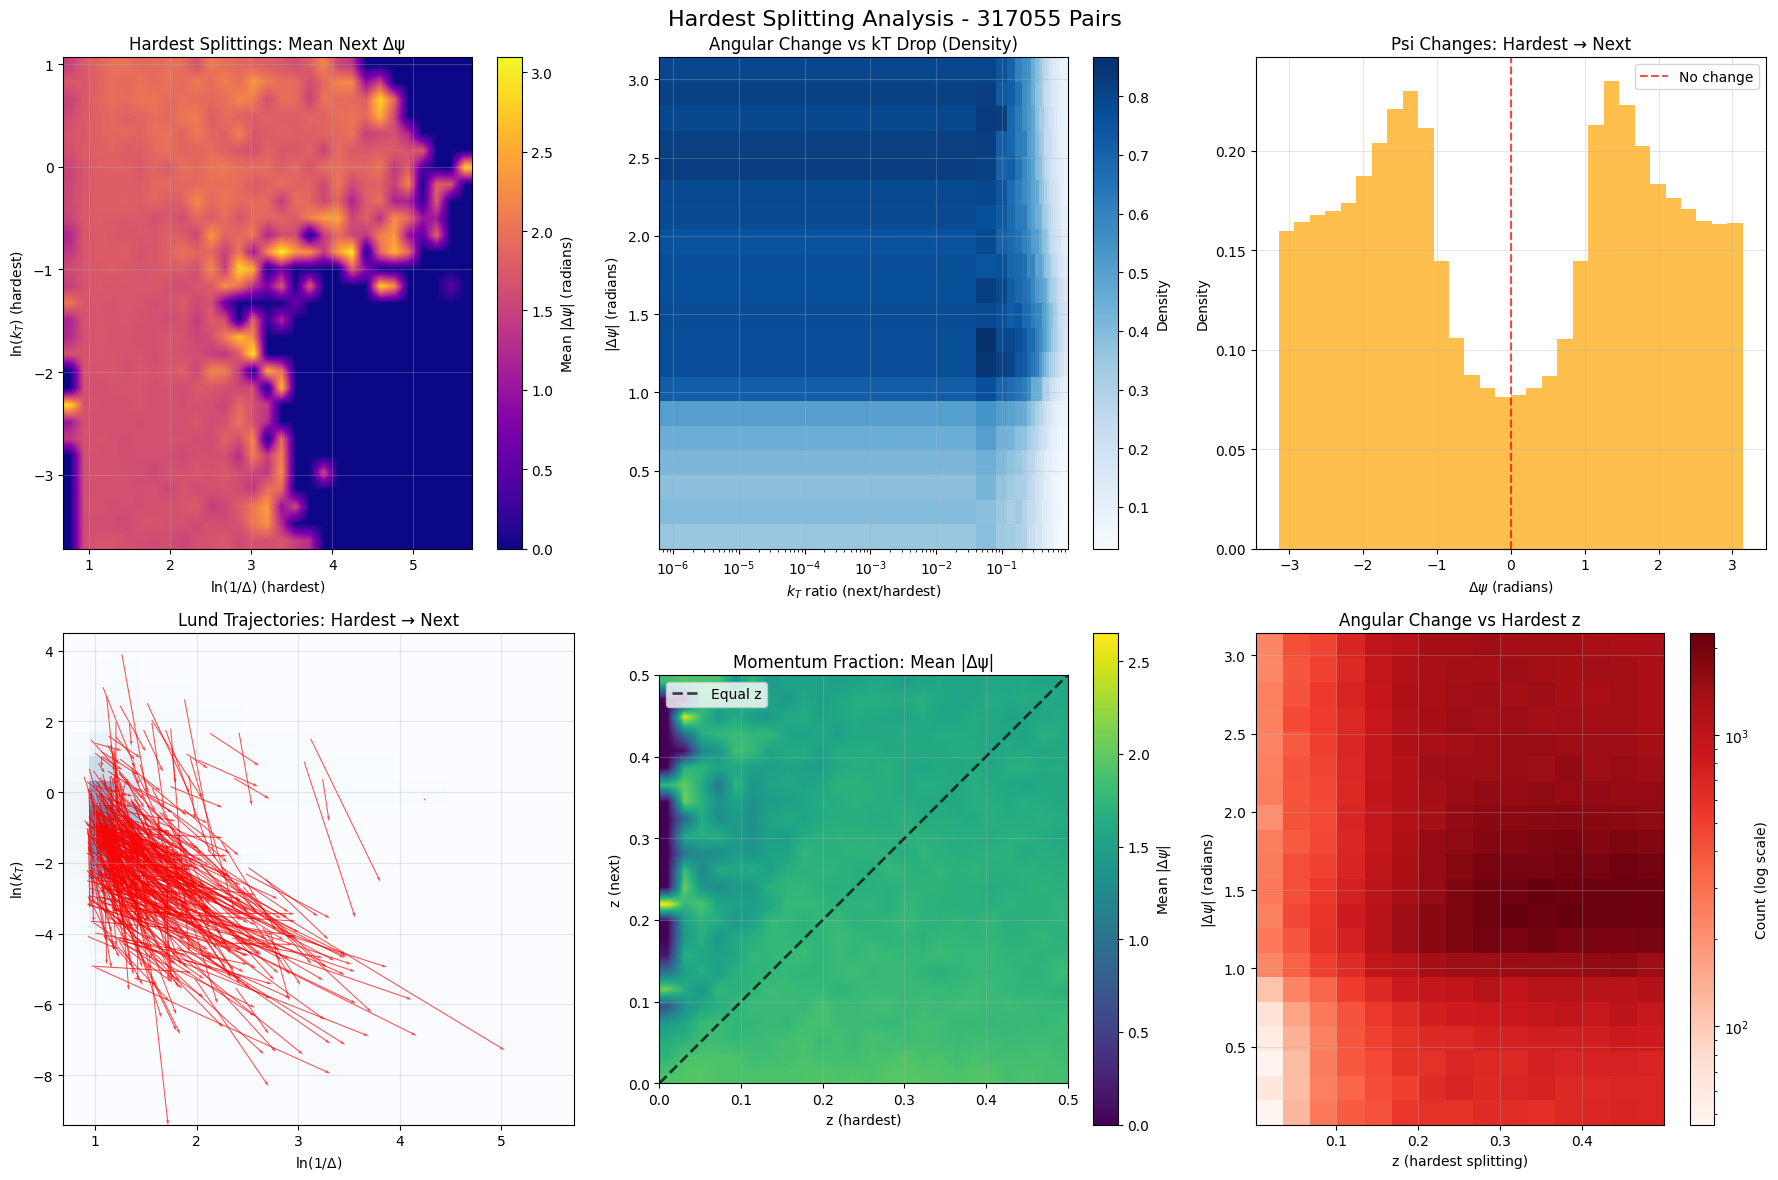

In [14]:
# Comprehensive visualization for hardest splitting pairs
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1) Hardest splittings in Lund plane as density plot, colored by next splitting's psi change
ax1 = axes[0, 0]
# Create bins for the 2D histogram
x_bins = np.linspace(df_hardest['hardest_ln_inv_delta'].min(), 
                     df_hardest['hardest_ln_inv_delta'].max(), 30)
y_bins = np.linspace(df_hardest['hardest_ln_kt'].quantile(0.05), 
                     df_hardest['hardest_ln_kt'].quantile(0.95), 30)

# Create weighted histogram where weights are the psi change magnitude
weights = np.abs(df_hardest['delta_psi'])
hist, x_edges, y_edges = np.histogram2d(df_hardest['hardest_ln_inv_delta'], 
                                       df_hardest['hardest_ln_kt'], 
                                       bins=[x_bins, y_bins], weights=weights)
# Normalize by counts to get mean psi change per bin
counts, _, _ = np.histogram2d(df_hardest['hardest_ln_inv_delta'], 
                             df_hardest['hardest_ln_kt'], 
                             bins=[x_bins, y_bins])
mean_psi_change = np.divide(hist, counts, out=np.zeros_like(hist), where=counts!=0)

# Plot the result
im = ax1.imshow(mean_psi_change.T, origin='lower', aspect='auto', 
                extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
                cmap='plasma', interpolation='bilinear')
plt.colorbar(im, ax=ax1, label=r'Mean $|\Delta\psi|$ (radians)')
ax1.set_xlabel(r'$\ln(1/\Delta)$ (hardest)')
ax1.set_ylabel(r'$\ln(k_T)$ (hardest)')
ax1.set_title('Hardest Splittings: Mean Next Δψ')
ax1.grid(True, alpha=0.3)

# 2) kT ratio vs psi change - density plot
ax2 = axes[0, 1]
# Use 2D histogram for density representation
h = ax2.hist2d(df_hardest['kt_ratio'], np.abs(df_hardest['delta_psi']), 
               bins=[25, 20], cmap='Blues', density=True)
plt.colorbar(h[3], ax=ax2, label='Density')
ax2.set_xlabel(r'$k_T$ ratio (next/hardest)')
ax2.set_ylabel(r'$|\Delta\psi|$ (radians)')
ax2.set_title('Angular Change vs kT Drop (Density)')
ax2.set_xscale('log')
ax2.grid(True, alpha=0.3)

# 3) Distribution of psi changes for hardest pairs only
ax3 = axes[0, 2]
ax3.hist(df_hardest['delta_psi'], bins=30, alpha=0.7, color='orange', density=True)
ax3.axvline(0, color='red', linestyle='--', alpha=0.7, label='No change')
ax3.set_xlabel(r'$\Delta\psi$ (radians)')
ax3.set_ylabel('Density')
ax3.set_title('Psi Changes: Hardest → Next')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4) Trajectory in Lund plane: hardest → next
ax4 = axes[1, 0]
# Background: density of hardest splittings
weights = np.ones_like(df_hardest['hardest_ln_inv_delta']) / len(df_jets)
ax4.hist2d(df_hardest['hardest_ln_inv_delta'], df_hardest['hardest_ln_kt'], 
           bins=[20, 20], cmap='Blues', alpha=0.6, weights=weights)

# Arrows showing trajectory from hardest to next
dx = df_hardest['next_ln_inv_delta'] - df_hardest['hardest_ln_inv_delta']
dy = df_hardest['next_ln_kt'] - df_hardest['hardest_ln_kt']

# Sample arrows to avoid overcrowding
n_arrows = min(500, len(df_hardest))
sample_idx = np.random.choice(len(df_hardest), n_arrows, replace=False)

ax4.quiver(df_hardest.iloc[sample_idx]['hardest_ln_inv_delta'], 
          df_hardest.iloc[sample_idx]['hardest_ln_kt'],
          dx.iloc[sample_idx], dy.iloc[sample_idx],
          angles='xy', scale_units='xy', scale=1, 
          width=0.002, color='red', alpha=0.7)

ax4.set_xlabel(r'$\ln(1/\Delta)$')
ax4.set_ylabel(r'$\ln(k_T)$')
ax4.set_title('Lund Trajectories: Hardest → Next')
ax4.grid(True, alpha=0.3)

# 5) z fraction comparison - density plot
ax5 = axes[1, 1]
# Create weighted histogram for density with psi change coloring
x_bins = np.linspace(0, 0.5, 25)
y_bins = np.linspace(0, 0.5, 25)

# Create weighted histogram where weights are the psi change magnitude
weights = np.abs(df_hardest['delta_psi'])
hist, x_edges, y_edges = np.histogram2d(df_hardest['hardest_z'], df_hardest['next_z'], 
                                       bins=[x_bins, y_bins], weights=weights)
# Normalize by counts to get mean psi change per bin
counts, _, _ = np.histogram2d(df_hardest['hardest_z'], df_hardest['next_z'], 
                             bins=[x_bins, y_bins])
mean_psi_change = np.divide(hist, counts, out=np.zeros_like(hist), where=counts!=0)

# Plot the result
im = ax5.imshow(mean_psi_change.T, origin='lower', aspect='equal', 
                extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]], 
                cmap='viridis', interpolation='bilinear')
ax5.plot([0, 0.5], [0, 0.5], 'k--', alpha=0.7, linewidth=2, label='Equal z')
plt.colorbar(im, ax=ax5, label=r'Mean $|\Delta\psi|$')
ax5.set_xlabel('z (hardest)')
ax5.set_ylabel('z (next)')
ax5.set_title('Momentum Fraction: Mean |Δψ|')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6) Angular change vs hardest splitting properties
ax6 = axes[1, 2]
# Create 2D histogram: hardest z vs angular change
h = ax6.hist2d(df_hardest['hardest_z'], np.abs(df_hardest['delta_psi']), 
               bins=[15, 20], cmap='Reds', norm=mcolors.LogNorm())
plt.colorbar(h[3], ax=ax6, label='Count (log scale)')
ax6.set_xlabel('z (hardest splitting)')
ax6.set_ylabel(r'$|\Delta\psi|$ (radians)')
ax6.set_title('Angular Change vs Hardest z')
ax6.grid(True, alpha=0.3)

plt.suptitle(f'Hardest Splitting Analysis - {len(df_hardest)} Pairs', fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
# Detailed analysis of angular patterns for hardest splitting pairs
print("=== HARDEST SPLITTING PAIR ANALYSIS ===\n")

# Basic statistics
print("Basic Statistics:")
print(f"  Total pairs analyzed: {len(df_hardest)}")
print(f"  Mean hardest kT: {df_hardest['hardest_kt'].mean():.3f}")
print(f"  Mean next kT: {df_hardest['next_kt'].mean():.3f}")
print(f"  Mean kT ratio (next/hardest): {df_hardest['kt_ratio'].mean():.3f}")
print(f"  Std kT ratio: {df_hardest['kt_ratio'].std():.3f}")
print()

# Angular change statistics
print("Angular Change Statistics:")
print(f"  Mean |Δψ|: {df_hardest['delta_psi'].abs().mean():.3f} radians ({np.degrees(df_hardest['delta_psi'].abs().mean()):.1f}°)")
print(f"  Std |Δψ|: {df_hardest['delta_psi'].abs().std():.3f} radians ({np.degrees(df_hardest['delta_psi'].abs().std()):.1f}°)")
print(f"  Max |Δψ|: {df_hardest['delta_psi'].abs().max():.3f} radians ({np.degrees(df_hardest['delta_psi'].abs().max()):.1f}°)")
print(f"  Fraction with |Δψ| > π/2: {(df_hardest['delta_psi'].abs() > np.pi/2).mean():.3f}")
print(f"  Fraction with |Δψ| > π/4: {(df_hardest['delta_psi'].abs() > np.pi/4).mean():.3f}")
print()

# Correlations
print("Correlation Analysis (for hardest pairs):")
corr_vars = ['delta_psi', 'kt_ratio', 'hardest_ln_kt', 'hardest_z', 'next_z']
correlations = df_hardest[corr_vars].corr()['delta_psi'].abs().sort_values(ascending=False)
for var, corr in correlations.items():
    if var != 'delta_psi':
        print(f"  |Δψ| vs {var}: {corr:.3f}")
print()

# Binned analysis by kT ratio
print("Angular Change vs kT Ratio (binned analysis):")
kt_ratio_bins = [0, 0.1, 0.2, 0.3, 0.5, 1.0]
for i in range(len(kt_ratio_bins)-1):
    mask = (df_hardest['kt_ratio'] >= kt_ratio_bins[i]) & (df_hardest['kt_ratio'] < kt_ratio_bins[i+1])
    if mask.sum() > 0:
        mean_psi = df_hardest[mask]['delta_psi'].abs().mean()
        count = mask.sum()
        print(f"  kT ratio [{kt_ratio_bins[i]:.1f}, {kt_ratio_bins[i+1]:.1f}): "
              f"<|Δψ|> = {mean_psi:.3f} rad ({np.degrees(mean_psi):.1f}°), N = {count}")
print()

# Examples of specific cases
print("Examples of extreme cases:")
# Highest angular change
max_psi_idx = df_hardest['delta_psi'].abs().idxmax()
print(f"  Largest |Δψ|: {df_hardest.loc[max_psi_idx, 'delta_psi']:.3f} rad "
      f"({np.degrees(df_hardest.loc[max_psi_idx, 'delta_psi']):.1f}°)")
print(f"    kT ratio: {df_hardest.loc[max_psi_idx, 'kt_ratio']:.3f}")
print(f"    Hardest kT: {df_hardest.loc[max_psi_idx, 'hardest_kt']:.3f}")

# Smallest angular change  
min_psi_idx = df_hardest['delta_psi'].abs().idxmin()
print(f"  Smallest |Δψ|: {df_hardest.loc[min_psi_idx, 'delta_psi']:.3f} rad "
      f"({np.degrees(df_hardest.loc[min_psi_idx, 'delta_psi']):.1f}°)")
print(f"    kT ratio: {df_hardest.loc[min_psi_idx, 'kt_ratio']:.3f}")
print(f"    Hardest kT: {df_hardest.loc[min_psi_idx, 'hardest_kt']:.3f}")

# Compare with all consecutive pairs (from previous analysis)
if 'df_psi' in locals():
    print(f"\nComparison with all consecutive pairs:")
    print(f"  All pairs mean |Δψ|: {df_psi['delta_psi'].abs().mean():.3f} rad")
    print(f"  Hardest pairs mean |Δψ|: {df_hardest['delta_psi'].abs().mean():.3f} rad")
    print(f"  Ratio (hardest/all): {df_hardest['delta_psi'].abs().mean() / df_psi['delta_psi'].abs().mean():.2f}")

=== HARDEST SPLITTING PAIR ANALYSIS ===

Basic Statistics:
  Total pairs analyzed: 317055
  Mean hardest kT: 0.798
  Mean next kT: 0.196
  Mean kT ratio (next/hardest): 0.320
  Std kT ratio: 0.248

Angular Change Statistics:
  Mean |Δψ|: 1.725 radians (98.9°)
  Std |Δψ|: 0.801 radians (45.9°)
  Max |Δψ|: 3.142 radians (180.0°)
  Fraction with |Δψ| > π/2: 0.559
  Fraction with |Δψ| > π/4: 0.865

Correlation Analysis (for hardest pairs):
  |Δψ| vs hardest_ln_kt: 0.002
  |Δψ| vs kt_ratio: 0.001
  |Δψ| vs hardest_z: 0.001
  |Δψ| vs next_z: 0.000

Angular Change vs kT Ratio (binned analysis):
  kT ratio [0.0, 0.1): <|Δψ|> = 1.758 rad (100.7°), N = 67554
  kT ratio [0.1, 0.2): <|Δψ|> = 1.740 rad (99.7°), N = 59759
  kT ratio [0.2, 0.3): <|Δψ|> = 1.722 rad (98.6°), N = 50298
  kT ratio [0.3, 0.5): <|Δψ|> = 1.712 rad (98.1°), N = 68258
  kT ratio [0.5, 1.0): <|Δψ|> = 1.698 rad (97.3°), N = 71186

Examples of extreme cases:
  Largest |Δψ|: 3.142 rad (180.0°)
    kT ratio: 0.275
    Hardest kT: 

=== SYMMETRIC PSI RANGE ANALYSIS [-π, π] ===
Loading data from saved_lunds.parquet...
Extracting consecutive splittings...
Extracting consecutive splittings...
Extracting hardest splitting pairs...
Extracting hardest splitting pairs...
Generating psi evolution analysis plots...
Generating psi evolution analysis plots...


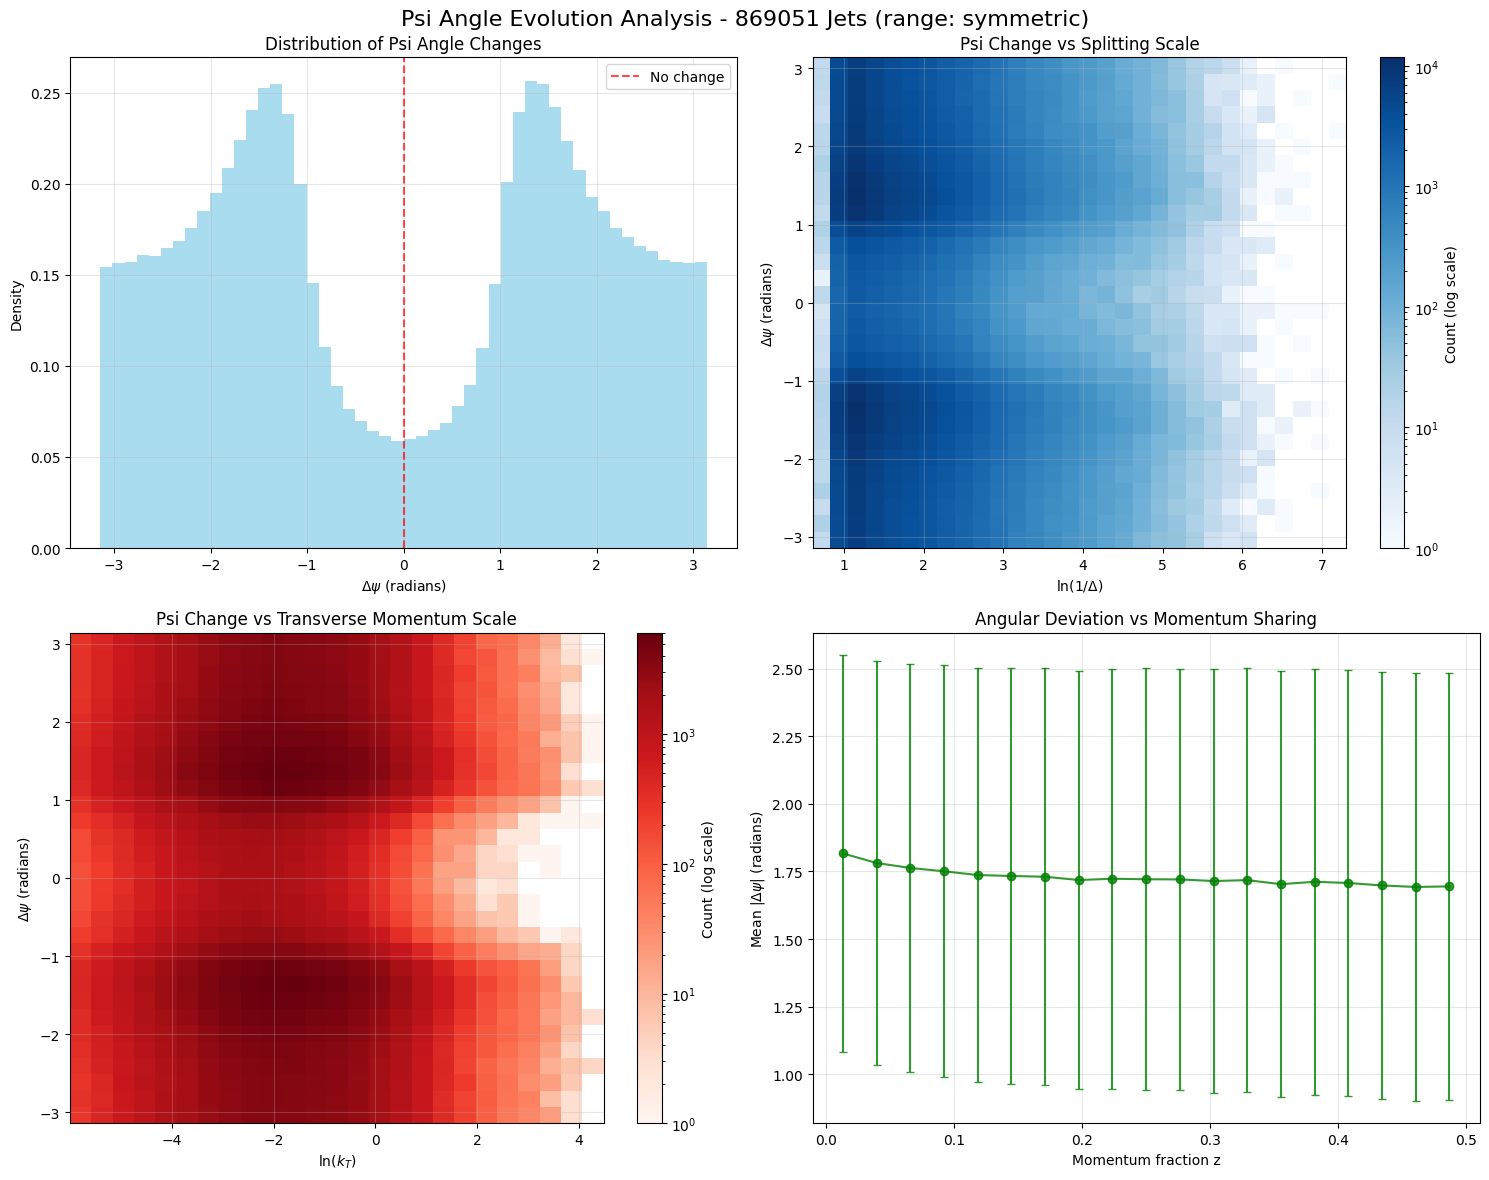

Generating hardest splitting analysis plots...


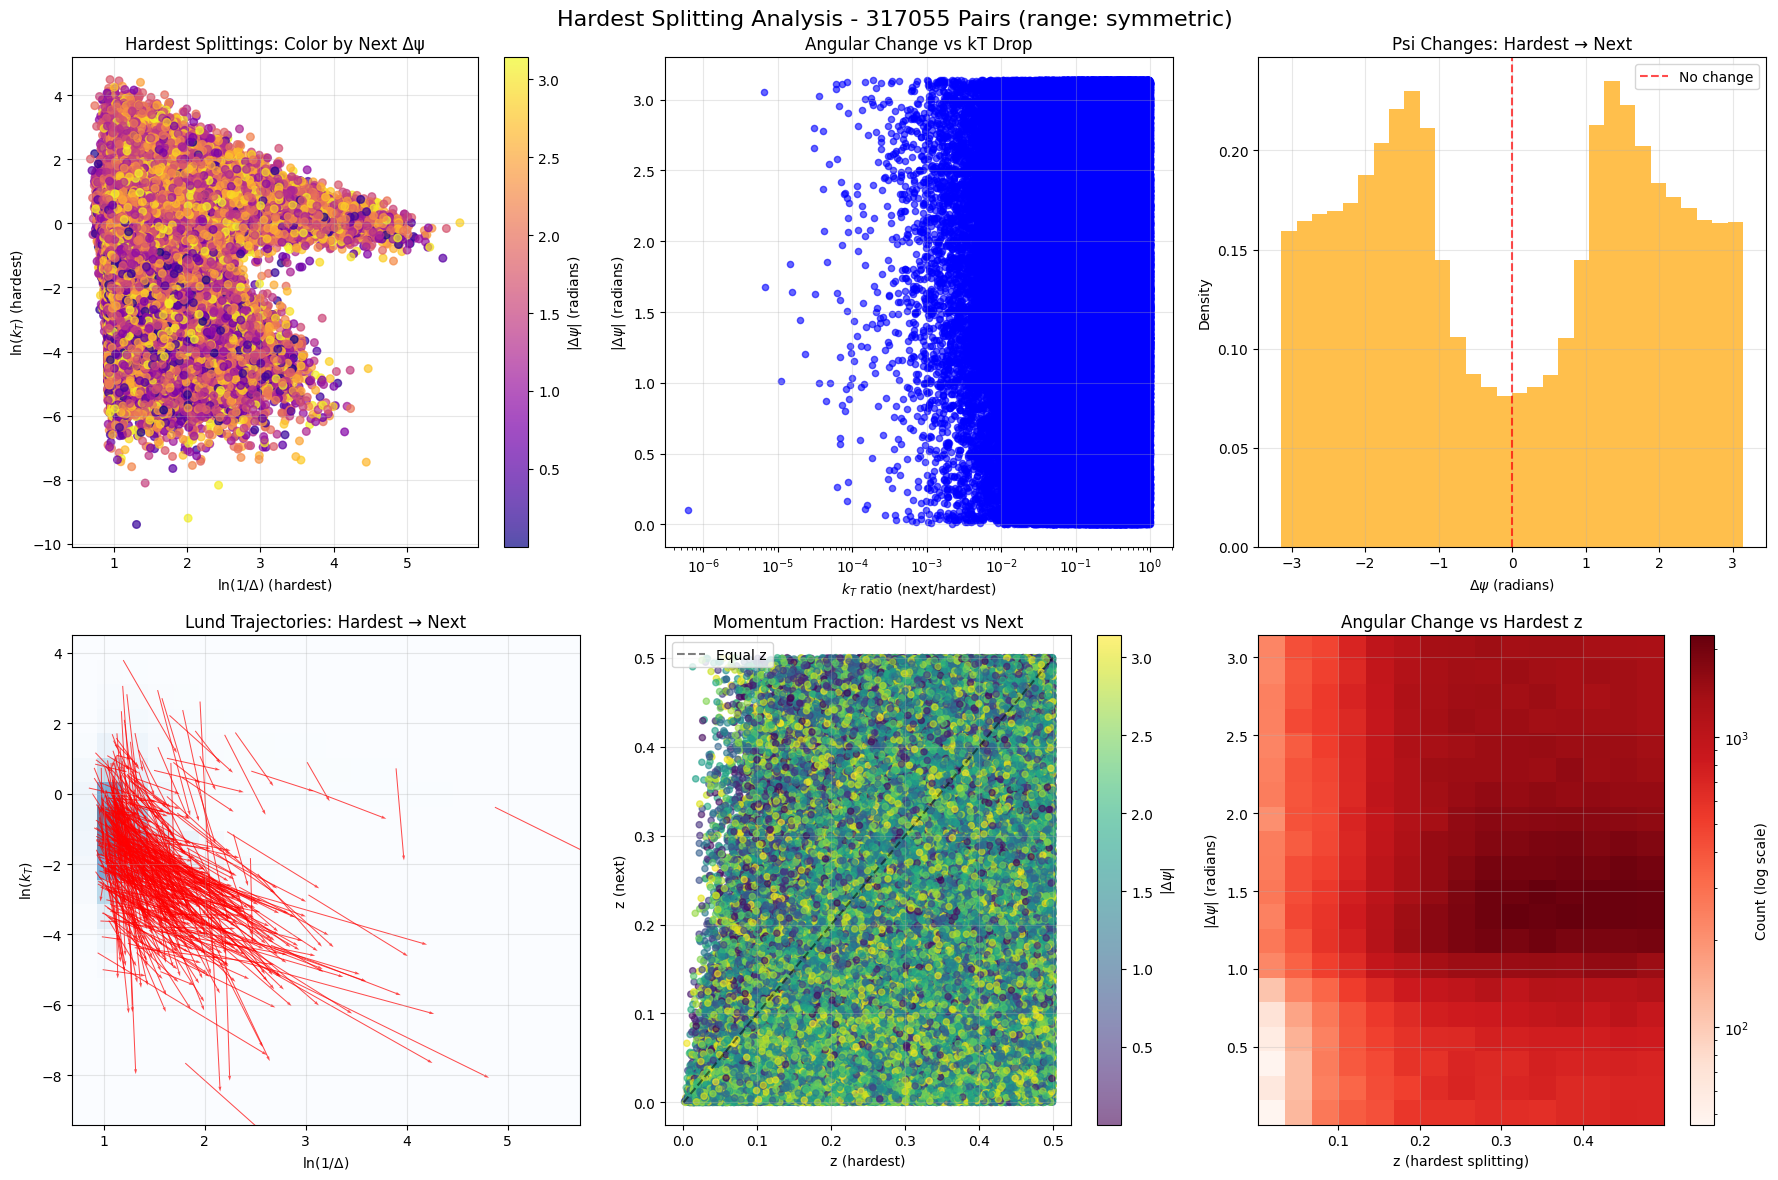

=== LUND SPLITTING ANALYSIS STATISTICS ===

General Statistics:
  Psi angle range: symmetric
  Total consecutive splitting pairs: 1124825
  Hardest splitting pairs: 317055

All Consecutive Pairs:
  Mean |Δψ|: 1.740 radians (99.7°)
  Std |Δψ|: 0.769 radians (44.1°)
  Fraction with |Δψ| > π/2: 0.561
  Fraction with |Δψ| > π/4: 0.888

Hardest Splitting Pairs:
  Mean hardest kT: 0.798
  Mean next kT: 0.196
  Mean kT ratio (next/hardest): 0.320
  Mean |Δψ|: 1.725 radians (98.9°)
  Ratio (hardest/all): 0.99

Correlation Analysis (hardest pairs):
  |Δψ| vs hardest_ln_kt: 0.002
  |Δψ| vs kt_ratio: 0.001
  |Δψ| vs hardest_z: 0.001
  |Δψ| vs next_z: 0.000


In [16]:
# Demonstration of the new lund_analysis.py module
# The module has been saved to /Users/ploskon/devel/jewel_project/lund_analysis.py

# Example usage:
import sys
sys.path.append('/Users/ploskon/devel/jewel_project')

# Import the module
from lund_analysis import analyze_lund_file, LundAnalyzer

print("=== SYMMETRIC PSI RANGE ANALYSIS [-π, π] ===")
# Analyze with symmetric psi range [-π, π]
results_symmetric = analyze_lund_file(
    parquet_file='saved_lunds.parquet',
    psi_range='symmetric',
    save_plots=False,
    output_dir='./'
)


=== POSITIVE PSI RANGE ANALYSIS [0, π] ===
Loading data from saved_lunds.parquet...
Extracting consecutive splittings...
Extracting consecutive splittings...
Extracting hardest splitting pairs...
Extracting hardest splitting pairs...
Generating psi evolution analysis plots...
Generating psi evolution analysis plots...


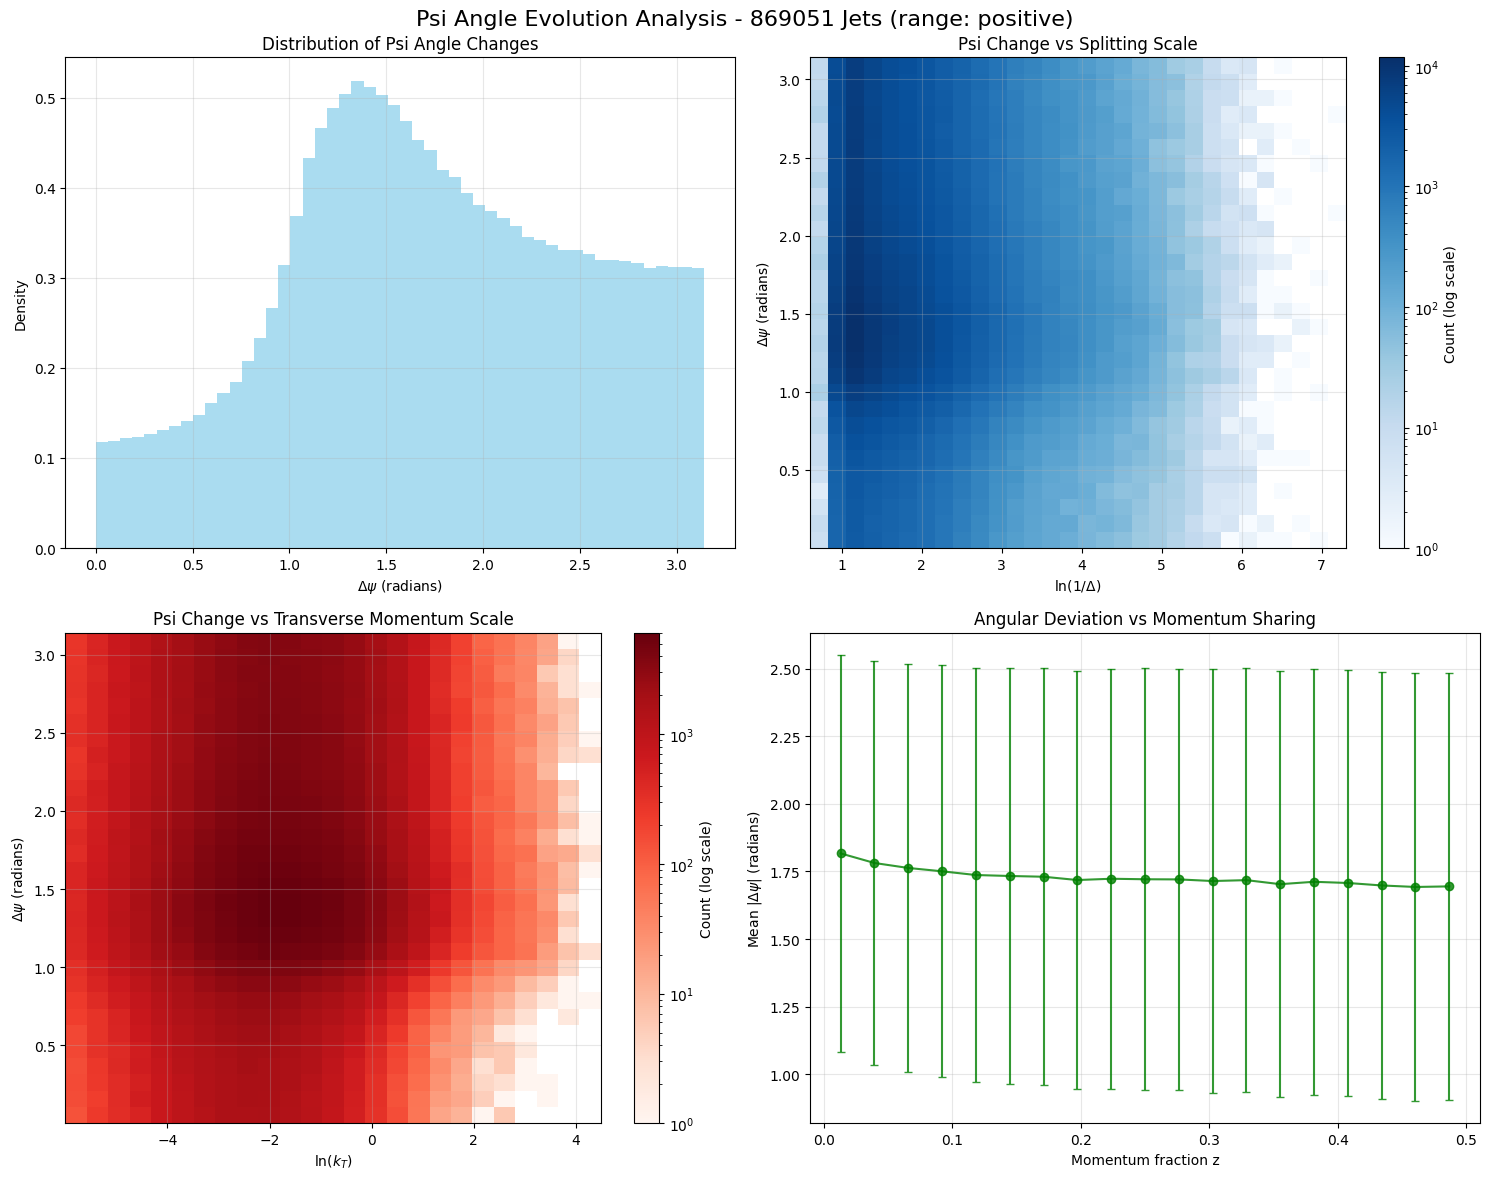

Generating hardest splitting analysis plots...


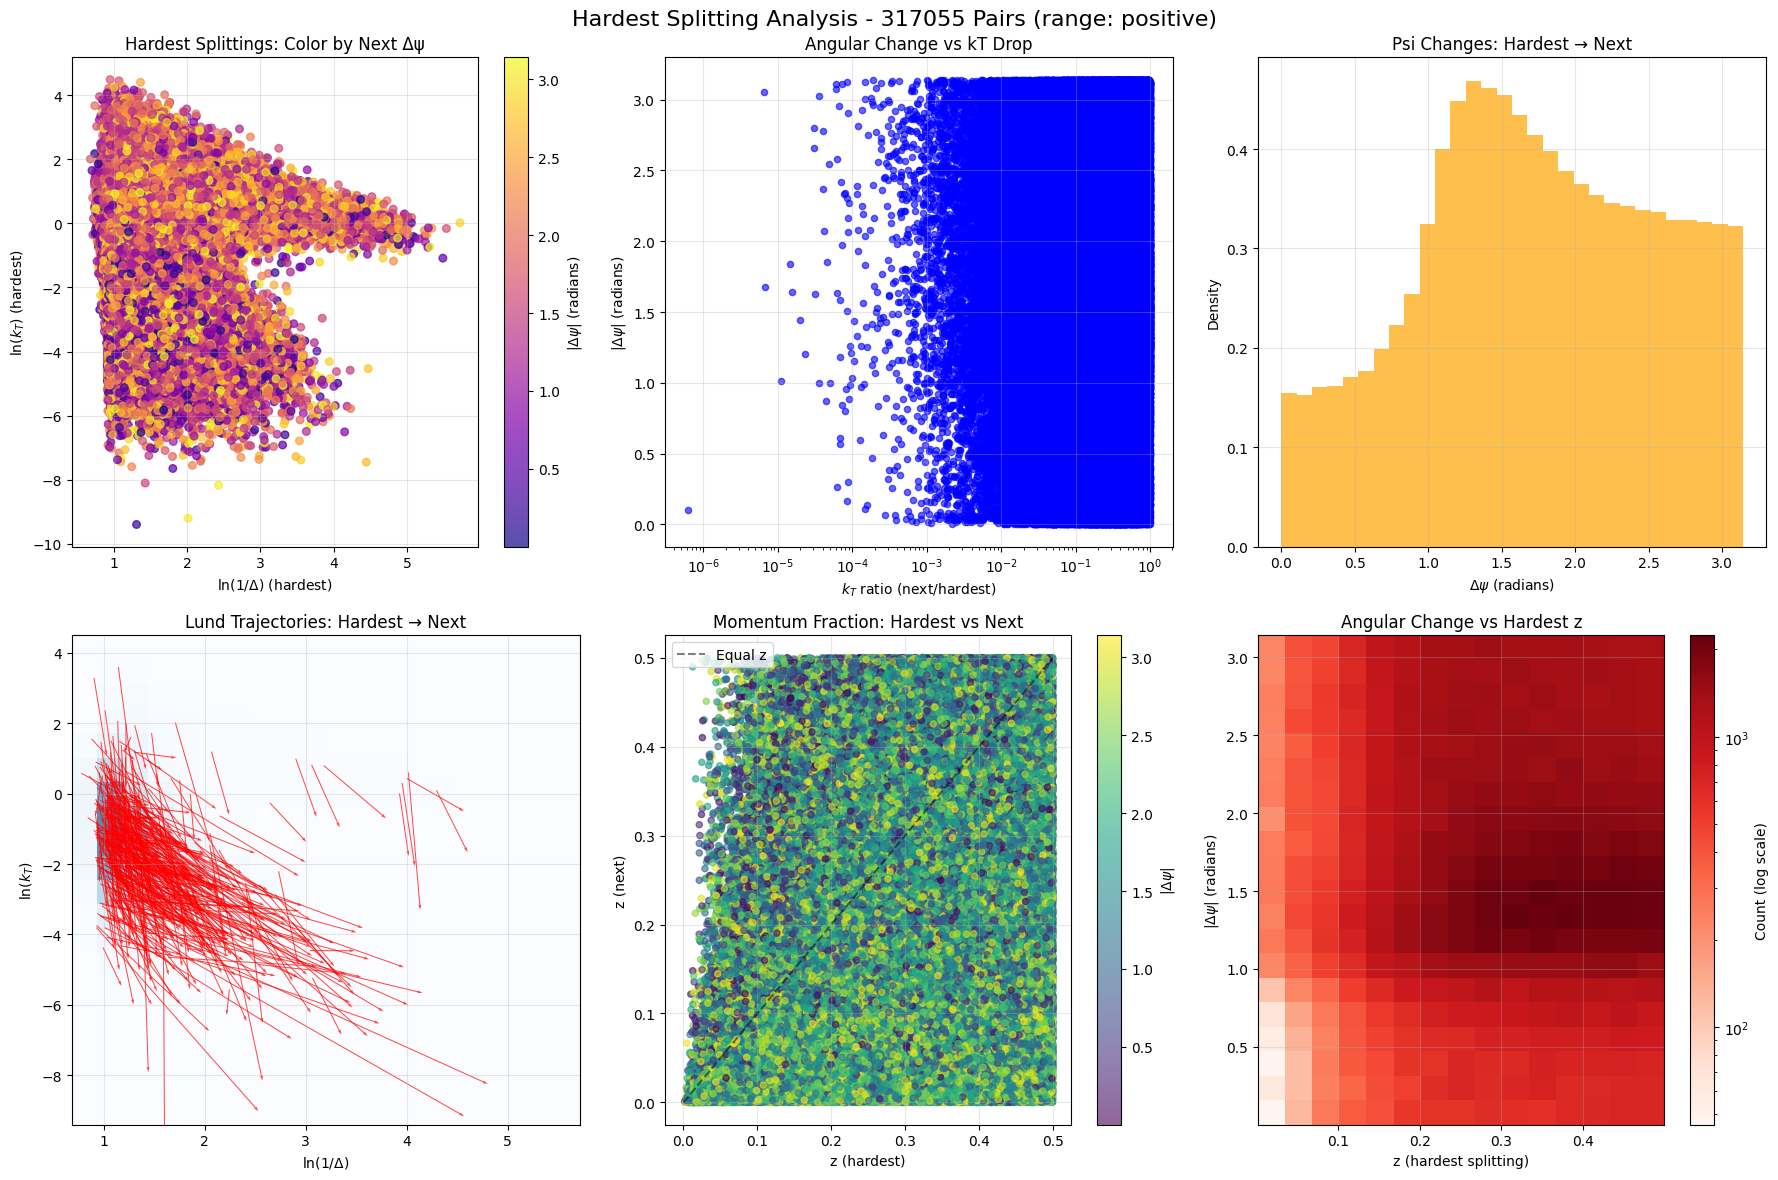

=== LUND SPLITTING ANALYSIS STATISTICS ===

General Statistics:
  Psi angle range: positive
  Total consecutive splitting pairs: 1124825
  Hardest splitting pairs: 317055

All Consecutive Pairs:
  Mean |Δψ|: 1.740 radians (99.7°)
  Std |Δψ|: 0.769 radians (44.1°)
  Fraction with Δψ > π/2: 0.561
  Fraction with Δψ > π/4: 0.888

Hardest Splitting Pairs:
  Mean hardest kT: 0.798
  Mean next kT: 0.196
  Mean kT ratio (next/hardest): 0.320
  Mean |Δψ|: 1.725 radians (98.9°)
  Ratio (hardest/all): 0.99

Correlation Analysis (hardest pairs):
  |Δψ| vs next_z: 0.118
  |Δψ| vs hardest_ln_kt: 0.089
  |Δψ| vs hardest_z: 0.032
  |Δψ| vs kt_ratio: 0.026


In [17]:
print("\n" + "="*50)
print("=== POSITIVE PSI RANGE ANALYSIS [0, π] ===")

# Analyze with positive psi range [0, π]
results_positive = analyze_lund_file(
    parquet_file='saved_lunds.parquet',
    psi_range='positive',
    save_plots=False,
    output_dir='./'
)

In [18]:
# Compare results between symmetric and positive ranges
print("\n" + "="*50)
print("=== COMPARISON BETWEEN APPROACHES ===")

print(f"Symmetric range [-π, π]:")
print(f"  Mean |Δψ| (all pairs): {results_symmetric['df_psi']['delta_psi'].abs().mean():.3f} rad")
print(f"  Mean |Δψ| (hardest pairs): {results_symmetric['df_hardest']['delta_psi'].abs().mean():.3f} rad")

print(f"\nPositive range [0, π]:")
print(f"  Mean Δψ (all pairs): {results_positive['df_psi']['delta_psi'].mean():.3f} rad")
print(f"  Mean Δψ (hardest pairs): {results_positive['df_hardest']['delta_psi'].mean():.3f} rad")

print("\n" + "="*50)
print("=== MANUAL USAGE EXAMPLES ===")

# Example of manual usage for more control
analyzer = LundAnalyzer(psi_range="symmetric")
df_jets = analyzer.load_lund_data('saved_lunds.parquet')

# Extract data
df_consecutive = analyzer.extract_consecutive_splittings(df_jets)
df_hardest_pairs = analyzer.extract_hardest_splitting_pairs(df_jets)

print(f"Manual extraction results:")
print(f"  Total jets: {len(df_jets)}")
print(f"  Consecutive pairs: {len(df_consecutive)}")
print(f"  Hardest pairs: {len(df_hardest_pairs)}")

# You can now use the data for custom analysis
# analyzer.plot_psi_evolution_analysis(df_consecutive, df_jets)
# analyzer.plot_hardest_splitting_analysis(df_hardest_pairs, df_jets)


=== COMPARISON BETWEEN APPROACHES ===
Symmetric range [-π, π]:
  Mean |Δψ| (all pairs): 1.740 rad
  Mean |Δψ| (hardest pairs): 1.725 rad

Positive range [0, π]:
  Mean Δψ (all pairs): 1.740 rad
  Mean Δψ (hardest pairs): 1.725 rad

=== MANUAL USAGE EXAMPLES ===
Manual extraction results:
  Total jets: 869051
  Consecutive pairs: 1124825
  Hardest pairs: 317055
Manual extraction results:
  Total jets: 869051
  Consecutive pairs: 1124825
  Hardest pairs: 317055


In [19]:
# Analysis: Splitting properties as a function of splitting order
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

# Extract splitting data with splitting index
splitting_data = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    for i, splitting in enumerate(lunds):
        # Convert psi to [0, π] range
        psi_original = splitting['psi']
        psi_positive = np.abs(psi_original)  # Map to [0, π]
        
        splitting_data.append({
            'jet_idx': jet_idx,
            'splitting_order': i,  # 0-based splitting index
            'ln_kt': np.log(splitting['kt']),
            'ln_inv_delta': np.log(1/splitting['delta']),
            'psi': psi_positive,  # Now in [0, π] range
            'z': splitting['z'],
            'kt': splitting['kt'],
            'delta': splitting['delta']
        })

df_splitting_order = pd.DataFrame(splitting_data)

print(f"Total splittings analyzed: {len(df_splitting_order)}")
print(f"Maximum splitting order: {df_splitting_order['splitting_order'].max()}")
print(f"Jets with at least 5 splittings: {(df_splitting_order.groupby('jet_idx')['splitting_order'].max() >= 4).sum()}")

# Calculate statistics by splitting order
max_order_to_plot = min(10, df_splitting_order['splitting_order'].max())  # Limit to first 10 splittings
order_stats = []

for order in range(max_order_to_plot + 1):
    order_data = df_splitting_order[df_splitting_order['splitting_order'] == order]
    
    if len(order_data) > 10:  # Require at least 10 splittings for statistics
        order_stats.append({
            'splitting_order': order,
            'count': len(order_data),
            'mean_ln_kt': order_data['ln_kt'].mean(),
            'std_ln_kt': order_data['ln_kt'].std(),
            'mean_ln_inv_delta': order_data['ln_inv_delta'].mean(),
            'std_ln_inv_delta': order_data['ln_inv_delta'].std(),
            'mean_psi': order_data['psi'].mean(),
            'std_psi': order_data['psi'].std(),
            'mean_z': order_data['z'].mean(),
            'std_z': order_data['z'].std()
        })

df_order_stats = pd.DataFrame(order_stats)
print(f"Splitting orders with sufficient statistics (>10 entries): {len(df_order_stats)}")

Total splittings analyzed: 1630269
Maximum splitting order: 21
Jets with at least 5 splittings: 116051
Splitting orders with sufficient statistics (>10 entries): 11


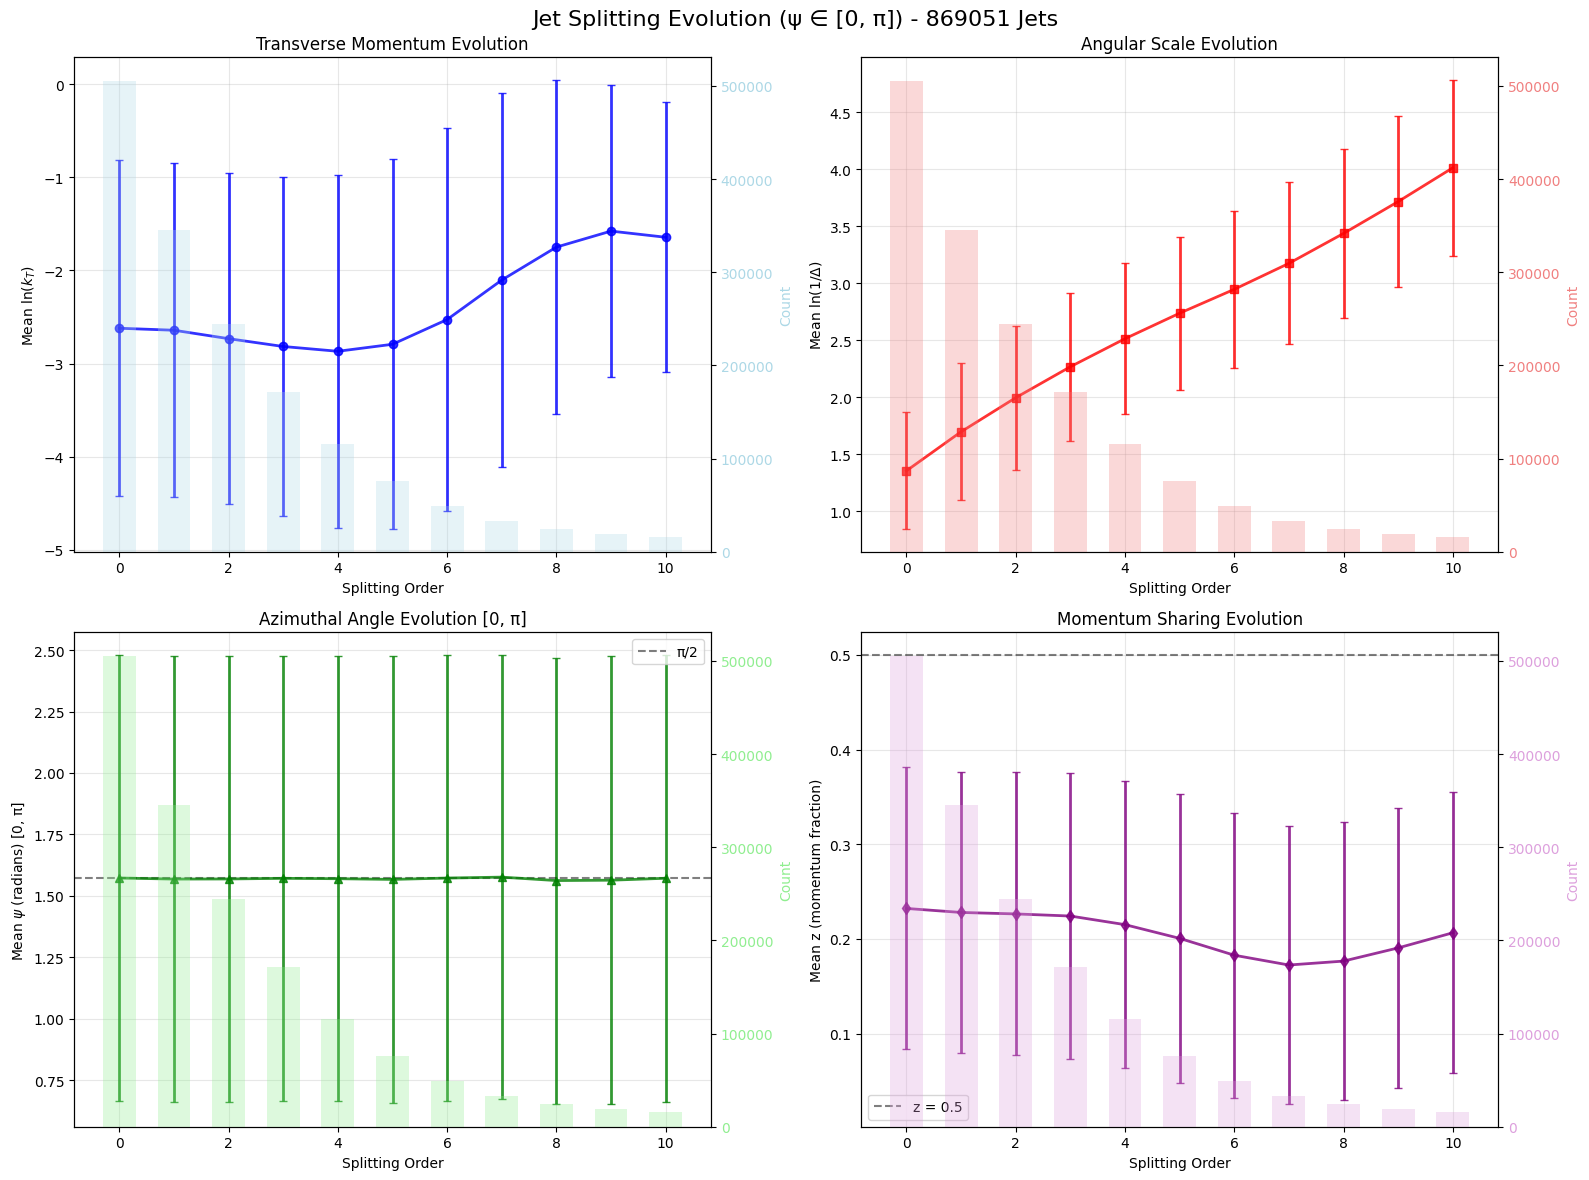


=== SPLITTING EVOLUTION SUMMARY (ψ ∈ [0, π]) ===
Splitting 0: N=505444, <ln(kT)>= -2.62±1.80, <ln(1/Δ)>=  1.36±0.51, <ψ>=  1.57±0.91, <z>=0.232±0.149
Splitting 1: N=344871, <ln(kT)>= -2.64±1.79, <ln(1/Δ)>=  1.70±0.60, <ψ>=  1.57±0.91, <z>=0.228±0.149
Splitting 2: N=244764, <ln(kT)>= -2.73±1.78, <ln(1/Δ)>=  2.00±0.63, <ψ>=  1.57±0.91, <z>=0.226±0.149
Splitting 3: N=171706, <ln(kT)>= -2.82±1.82, <ln(1/Δ)>=  2.27±0.65, <ψ>=  1.57±0.91, <z>=0.224±0.151
Splitting 4: N=116051, <ln(kT)>= -2.87±1.90, <ln(1/Δ)>=  2.51±0.66, <ψ>=  1.57±0.90, <z>=0.215±0.152
Splitting 5: N=75919, <ln(kT)>= -2.79±1.99, <ln(1/Δ)>=  2.74±0.67, <ψ>=  1.57±0.91, <z>=0.201±0.153
Splitting 6: N=49293, <ln(kT)>= -2.53±2.05, <ln(1/Δ)>=  2.95±0.69, <ψ>=  1.57±0.91, <z>=0.183±0.150
Splitting 7: N=33482, <ln(kT)>= -2.10±2.01, <ln(1/Δ)>=  3.18±0.71, <ψ>=  1.58±0.90, <z>=0.172±0.147
Splitting 8: N=24883, <ln(kT)>= -1.75±1.80, <ln(1/Δ)>=  3.44±0.74, <ψ>=  1.56±0.91, <z>=0.177±0.147
Splitting 9: N=19494, <ln(kT)>= -1.58±1.57, <

In [20]:
# Create comprehensive visualization of splitting evolution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) ln(kt) vs splitting order
ax1 = axes[0, 0]
ax1.errorbar(df_order_stats['splitting_order'], df_order_stats['mean_ln_kt'], 
             yerr=df_order_stats['std_ln_kt'], 
             marker='o', capsize=3, color='blue', alpha=0.8, linewidth=2)
ax1.set_xlabel('Splitting Order')
ax1.set_ylabel(r'Mean $\ln(k_T)$')
ax1.set_title('Transverse Momentum Evolution')
ax1.grid(True, alpha=0.3)

# Add count information as secondary y-axis
ax1_twin = ax1.twinx()
ax1_twin.bar(df_order_stats['splitting_order'], df_order_stats['count'], 
             alpha=0.3, color='lightblue', width=0.6)
ax1_twin.set_ylabel('Count', color='lightblue')
ax1_twin.tick_params(axis='y', labelcolor='lightblue')

# 2) ln(1/delta) vs splitting order
ax2 = axes[0, 1]
ax2.errorbar(df_order_stats['splitting_order'], df_order_stats['mean_ln_inv_delta'], 
             yerr=df_order_stats['std_ln_inv_delta'], 
             marker='s', capsize=3, color='red', alpha=0.8, linewidth=2)
ax2.set_xlabel('Splitting Order')
ax2.set_ylabel(r'Mean $\ln(1/\Delta)$')
ax2.set_title('Angular Scale Evolution')
ax2.grid(True, alpha=0.3)

# Add count information
ax2_twin = ax2.twinx()
ax2_twin.bar(df_order_stats['splitting_order'], df_order_stats['count'], 
             alpha=0.3, color='lightcoral', width=0.6)
ax2_twin.set_ylabel('Count', color='lightcoral')
ax2_twin.tick_params(axis='y', labelcolor='lightcoral')

# 3) psi vs splitting order
ax3 = axes[1, 0]
ax3.errorbar(df_order_stats['splitting_order'], df_order_stats['mean_psi'], 
             yerr=df_order_stats['std_psi'], 
             marker='^', capsize=3, color='green', alpha=0.8, linewidth=2)
ax3.set_xlabel('Splitting Order')
ax3.set_ylabel(r'Mean $\psi$ (radians) [0, π]')
ax3.set_title('Azimuthal Angle Evolution [0, π]')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.5, label='π/2')
ax3.legend()

# Add count information
ax3_twin = ax3.twinx()
ax3_twin.bar(df_order_stats['splitting_order'], df_order_stats['count'], 
             alpha=0.3, color='lightgreen', width=0.6)
ax3_twin.set_ylabel('Count', color='lightgreen')
ax3_twin.tick_params(axis='y', labelcolor='lightgreen')

# 4) z vs splitting order
ax4 = axes[1, 1]
ax4.errorbar(df_order_stats['splitting_order'], df_order_stats['mean_z'], 
             yerr=df_order_stats['std_z'], 
             marker='d', capsize=3, color='purple', alpha=0.8, linewidth=2)
ax4.set_xlabel('Splitting Order')
ax4.set_ylabel('Mean z (momentum fraction)')
ax4.set_title('Momentum Sharing Evolution')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='z = 0.5')
ax4.legend()

# Add count information
ax4_twin = ax4.twinx()
ax4_twin.bar(df_order_stats['splitting_order'], df_order_stats['count'], 
             alpha=0.3, color='plum', width=0.6)
ax4_twin.set_ylabel('Count', color='plum')
ax4_twin.tick_params(axis='y', labelcolor='plum')

plt.suptitle(f'Jet Splitting Evolution (ψ ∈ [0, π]) - {len(df_jets)} Jets', fontsize=16)
plt.tight_layout()
plt.show()

# Print numerical summary
print("\n=== SPLITTING EVOLUTION SUMMARY (ψ ∈ [0, π]) ===")
for _, row in df_order_stats.iterrows():
    order = int(row['splitting_order'])
    print(f"Splitting {order}: N={int(row['count']):>5d}, "
          f"<ln(kT)>={row['mean_ln_kt']:>6.2f}±{row['std_ln_kt']:.2f}, "
          f"<ln(1/Δ)>={row['mean_ln_inv_delta']:>6.2f}±{row['std_ln_inv_delta']:.2f}, "
          f"<ψ>={row['mean_psi']:>6.2f}±{row['std_psi']:.2f}, "
          f"<z>={row['mean_z']:>5.3f}±{row['std_z']:.3f}")

# Calculate trends
if len(df_order_stats) > 2:
    print(f"\n=== EVOLUTION TRENDS (ψ ∈ [0, π]) ===")
    
    # Linear fits for trends
    orders = df_order_stats['splitting_order'].values
    
    # ln(kt) trend
    kt_slope = np.polyfit(orders, df_order_stats['mean_ln_kt'], 1)[0]
    print(f"ln(kT) slope: {kt_slope:.3f} per splitting (negative = decreasing kT)")
    
    # ln(1/delta) trend  
    delta_slope = np.polyfit(orders, df_order_stats['mean_ln_inv_delta'], 1)[0]
    print(f"ln(1/Δ) slope: {delta_slope:.3f} per splitting (positive = decreasing angles)")
    
    # z trend
    z_slope = np.polyfit(orders, df_order_stats['mean_z'], 1)[0]
    print(f"z slope: {z_slope:.4f} per splitting")
    
    # Psi trend (now in [0, π] range)
    psi_slope = np.polyfit(orders, df_order_stats['mean_psi'], 1)[0]
    print(f"ψ slope: {psi_slope:.4f} rad per splitting (range [0, π])")

In [21]:
# Analysis: Splitting properties starting from the hardest kT splitting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

# Extract splitting data starting from the hardest kT splitting in each jet
splitting_data_from_hardest = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    if len(lunds) == 0:
        continue
    
    # Find the index of the splitting with maximum kT
    kt_values = [l['kt'] for l in lunds]
    max_kt_idx = np.argmax(kt_values)
    
    # Only consider splittings from max_kt_idx onwards
    for i, splitting in enumerate(lunds[max_kt_idx:]):
        # Convert psi to [0, π] range
        psi_original = splitting['psi']
        psi_positive = np.abs(psi_original)  # Map to [0, π]
        
        splitting_data_from_hardest.append({
            'jet_idx': jet_idx,
            'splitting_order': i,  # 0-based splitting index from hardest splitting
            'original_index': max_kt_idx + i,  # Original index in the full sequence
            'ln_kt': np.log(splitting['kt']),
            'ln_inv_delta': np.log(1/splitting['delta']),
            'psi': psi_positive,  # Now in [0, π] range
            'z': splitting['z'],
            'kt': splitting['kt'],
            'delta': splitting['delta']
        })

df_splitting_from_hardest = pd.DataFrame(splitting_data_from_hardest)

print(f"Total splittings analyzed (from hardest onwards): {len(df_splitting_from_hardest)}")
print(f"Maximum splitting order (from hardest): {df_splitting_from_hardest['splitting_order'].max()}")
print(f"Jets with at least 3 splittings after hardest: {(df_splitting_from_hardest.groupby('jet_idx')['splitting_order'].max() >= 2).sum()}")
print(f"Jets contributing to analysis: {df_splitting_from_hardest['jet_idx'].nunique()}")

# Show some examples of hardest splitting positions
hardest_positions = df_splitting_from_hardest[df_splitting_from_hardest['splitting_order'] == 0]['original_index']
print(f"Hardest splitting positions in original sequences - mean: {hardest_positions.mean():.1f}, std: {hardest_positions.std():.1f}")

# Calculate statistics by splitting order (from hardest)
max_order_to_plot = min(8, df_splitting_from_hardest['splitting_order'].max())  # Limit to first 8 splittings after hardest
order_stats_hardest = []

for order in range(max_order_to_plot + 1):
    order_data = df_splitting_from_hardest[df_splitting_from_hardest['splitting_order'] == order]
    
    if len(order_data) > 10:  # Require at least 10 splittings for statistics
        order_stats_hardest.append({
            'splitting_order': order,
            'count': len(order_data),
            'mean_ln_kt': order_data['ln_kt'].mean(),
            'std_ln_kt': order_data['ln_kt'].std(),
            'mean_ln_inv_delta': order_data['ln_inv_delta'].mean(),
            'std_ln_inv_delta': order_data['ln_inv_delta'].std(),
            'mean_psi': order_data['psi'].mean(),
            'std_psi': order_data['psi'].std(),
            'mean_z': order_data['z'].mean(),
            'std_z': order_data['z'].std()
        })

df_order_stats_hardest = pd.DataFrame(order_stats_hardest)
print(f"Splitting orders with sufficient statistics (>10 entries): {len(df_order_stats_hardest)}")

Total splittings analyzed (from hardest onwards): 1424802
Maximum splitting order (from hardest): 19
Jets with at least 3 splittings after hardest: 214868
Jets contributing to analysis: 505444
Hardest splitting positions in original sequences - mean: 0.4, std: 1.0
Splitting orders with sufficient statistics (>10 entries): 9


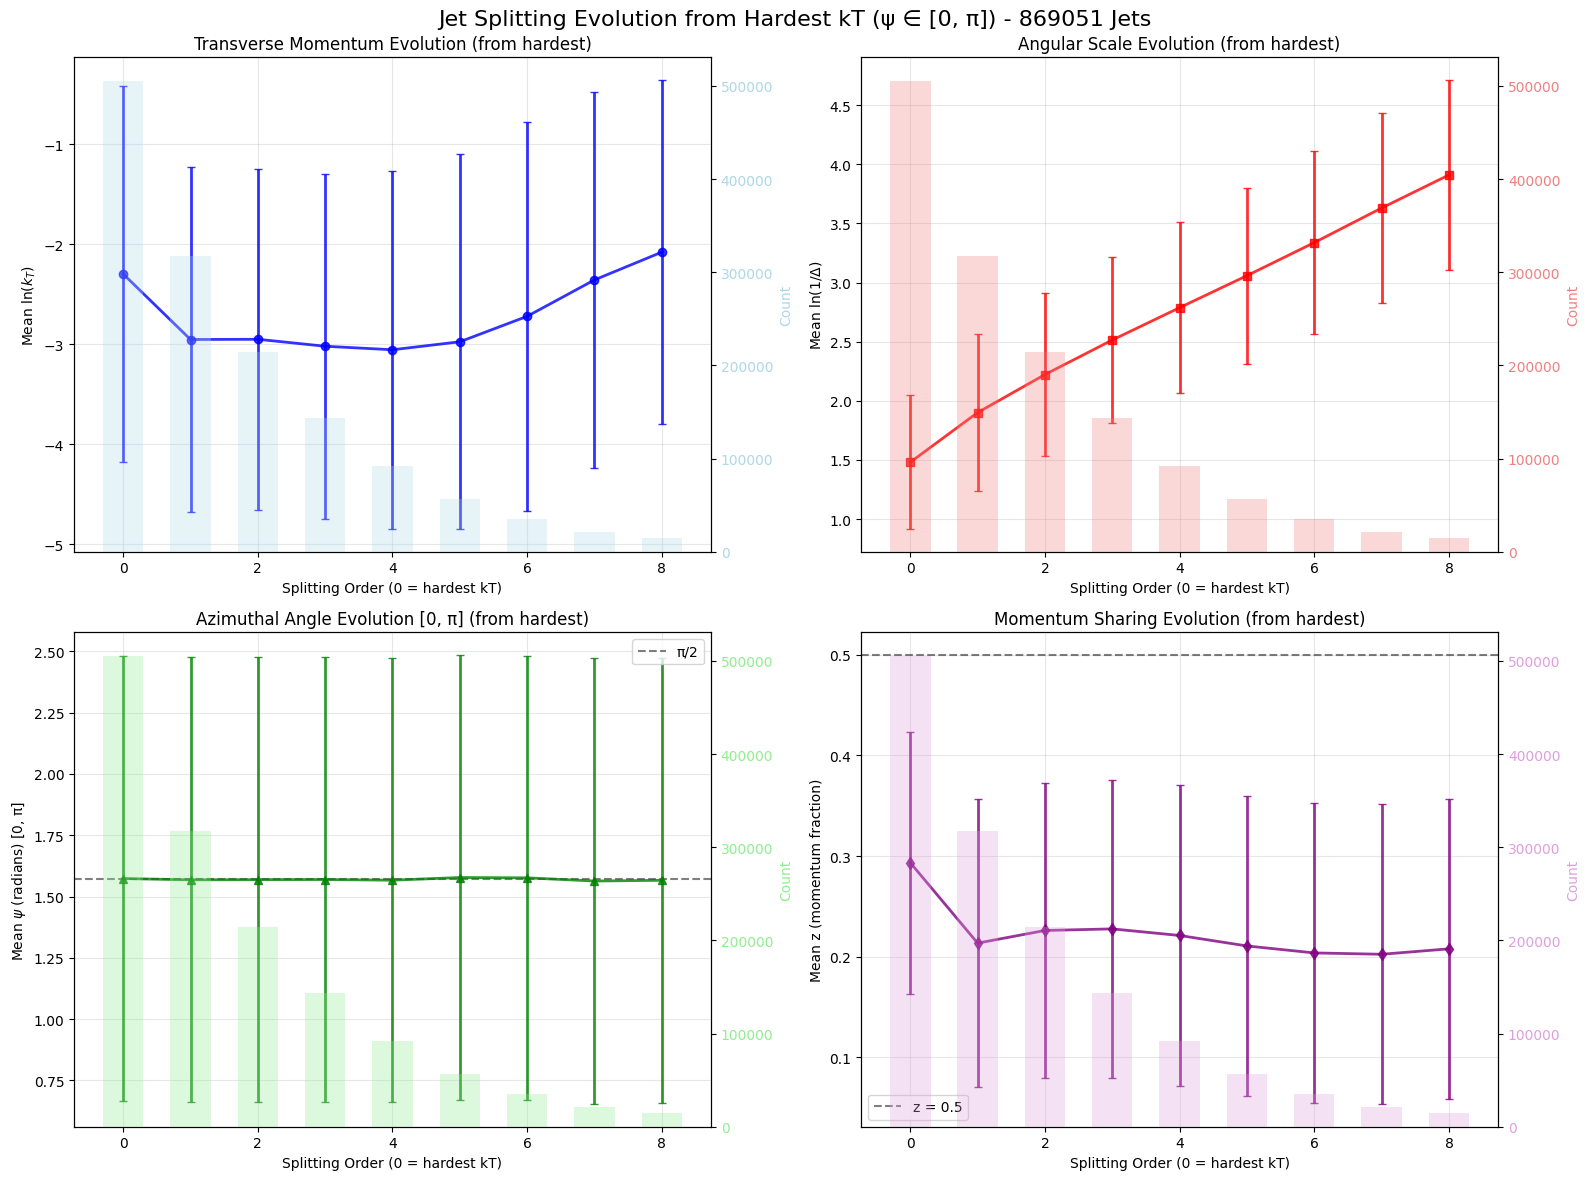


=== SPLITTING EVOLUTION FROM HARDEST kT (ψ ∈ [0, π]) ===
Splitting Hardest: N=505444, <ln(kT)>= -2.30±1.88, <ln(1/Δ)>=  1.48±0.57, <ψ>=  1.57±0.91, <z>=0.293±0.130
Splitting Hard+1: N=317055, <ln(kT)>= -2.95±1.73, <ln(1/Δ)>=  1.90±0.67, <ψ>=  1.57±0.91, <z>=0.213±0.143
Splitting Hard+2: N=214868, <ln(kT)>= -2.95±1.70, <ln(1/Δ)>=  2.22±0.69, <ψ>=  1.57±0.91, <z>=0.226±0.147
Splitting Hard+3: N=143762, <ln(kT)>= -3.02±1.72, <ln(1/Δ)>=  2.51±0.70, <ψ>=  1.57±0.91, <z>=0.228±0.148
Splitting Hard+4: N=91949, <ln(kT)>= -3.05±1.79, <ln(1/Δ)>=  2.79±0.72, <ψ>=  1.57±0.91, <z>=0.221±0.150
Splitting Hard+5: N=56798, <ln(kT)>= -2.97±1.87, <ln(1/Δ)>=  3.06±0.75, <ψ>=  1.58±0.91, <z>=0.211±0.150
Splitting Hard+6: N=34655, <ln(kT)>= -2.72±1.95, <ln(1/Δ)>=  3.34±0.78, <ψ>=  1.58±0.91, <z>=0.204±0.149
Splitting Hard+7: N=21698, <ln(kT)>= -2.35±1.88, <ln(1/Δ)>=  3.63±0.80, <ψ>=  1.56±0.91, <z>=0.202±0.149
Splitting Hard+8: N=14386, <ln(kT)>= -2.08±1.72, <ln(1/Δ)>=  3.91±0.80, <ψ>=  1.57±0.91, <z>=0.20

In [22]:
# Create comprehensive visualization of splitting evolution from hardest kT
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1) ln(kt) vs splitting order (from hardest)
ax1 = axes[0, 0]
ax1.errorbar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['mean_ln_kt'], 
             yerr=df_order_stats_hardest['std_ln_kt'], 
             marker='o', capsize=3, color='blue', alpha=0.8, linewidth=2)
ax1.set_xlabel('Splitting Order (0 = hardest kT)')
ax1.set_ylabel(r'Mean $\ln(k_T)$')
ax1.set_title('Transverse Momentum Evolution (from hardest)')
ax1.grid(True, alpha=0.3)

# Add count information as secondary y-axis
ax1_twin = ax1.twinx()
ax1_twin.bar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['count'], 
             alpha=0.3, color='lightblue', width=0.6)
ax1_twin.set_ylabel('Count', color='lightblue')
ax1_twin.tick_params(axis='y', labelcolor='lightblue')

# 2) ln(1/delta) vs splitting order (from hardest)
ax2 = axes[0, 1]
ax2.errorbar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['mean_ln_inv_delta'], 
             yerr=df_order_stats_hardest['std_ln_inv_delta'], 
             marker='s', capsize=3, color='red', alpha=0.8, linewidth=2)
ax2.set_xlabel('Splitting Order (0 = hardest kT)')
ax2.set_ylabel(r'Mean $\ln(1/\Delta)$')
ax2.set_title('Angular Scale Evolution (from hardest)')
ax2.grid(True, alpha=0.3)

# Add count information
ax2_twin = ax2.twinx()
ax2_twin.bar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['count'], 
             alpha=0.3, color='lightcoral', width=0.6)
ax2_twin.set_ylabel('Count', color='lightcoral')
ax2_twin.tick_params(axis='y', labelcolor='lightcoral')

# 3) psi vs splitting order (from hardest)
ax3 = axes[1, 0]
ax3.errorbar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['mean_psi'], 
             yerr=df_order_stats_hardest['std_psi'], 
             marker='^', capsize=3, color='green', alpha=0.8, linewidth=2)
ax3.set_xlabel('Splitting Order (0 = hardest kT)')
ax3.set_ylabel(r'Mean $\psi$ (radians) [0, π]')
ax3.set_title('Azimuthal Angle Evolution [0, π] (from hardest)')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.5, label='π/2')
ax3.legend()

# Add count information
ax3_twin = ax3.twinx()
ax3_twin.bar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['count'], 
             alpha=0.3, color='lightgreen', width=0.6)
ax3_twin.set_ylabel('Count', color='lightgreen')
ax3_twin.tick_params(axis='y', labelcolor='lightgreen')

# 4) z vs splitting order (from hardest)
ax4 = axes[1, 1]
ax4.errorbar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['mean_z'], 
             yerr=df_order_stats_hardest['std_z'], 
             marker='d', capsize=3, color='purple', alpha=0.8, linewidth=2)
ax4.set_xlabel('Splitting Order (0 = hardest kT)')
ax4.set_ylabel('Mean z (momentum fraction)')
ax4.set_title('Momentum Sharing Evolution (from hardest)')
ax4.grid(True, alpha=0.3)
ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='z = 0.5')
ax4.legend()

# Add count information
ax4_twin = ax4.twinx()
ax4_twin.bar(df_order_stats_hardest['splitting_order'], df_order_stats_hardest['count'], 
             alpha=0.3, color='plum', width=0.6)
ax4_twin.set_ylabel('Count', color='plum')
ax4_twin.tick_params(axis='y', labelcolor='plum')

plt.suptitle(f'Jet Splitting Evolution from Hardest kT (ψ ∈ [0, π]) - {len(df_jets)} Jets', fontsize=16)
plt.tight_layout()
plt.show()

# Print numerical summary
print("\n=== SPLITTING EVOLUTION FROM HARDEST kT (ψ ∈ [0, π]) ===")
for _, row in df_order_stats_hardest.iterrows():
    order = int(row['splitting_order'])
    order_label = "Hardest" if order == 0 else f"Hard+{order}"
    print(f"Splitting {order_label}: N={int(row['count']):>5d}, "
          f"<ln(kT)>={row['mean_ln_kt']:>6.2f}±{row['std_ln_kt']:.2f}, "
          f"<ln(1/Δ)>={row['mean_ln_inv_delta']:>6.2f}±{row['std_ln_inv_delta']:.2f}, "
          f"<ψ>={row['mean_psi']:>6.2f}±{row['std_psi']:.2f}, "
          f"<z>={row['mean_z']:>5.3f}±{row['std_z']:.3f}")

# Calculate trends
if len(df_order_stats_hardest) > 2:
    print(f"\n=== EVOLUTION TRENDS FROM HARDEST kT (ψ ∈ [0, π]) ===")
    
    # Linear fits for trends
    orders = df_order_stats_hardest['splitting_order'].values
    
    # ln(kt) trend
    kt_slope = np.polyfit(orders, df_order_stats_hardest['mean_ln_kt'], 1)[0]
    print(f"ln(kT) slope: {kt_slope:.3f} per splitting (negative = decreasing kT)")
    
    # ln(1/delta) trend  
    delta_slope = np.polyfit(orders, df_order_stats_hardest['mean_ln_inv_delta'], 1)[0]
    print(f"ln(1/Δ) slope: {delta_slope:.3f} per splitting (positive = decreasing angles)")
    
    # z trend
    z_slope = np.polyfit(orders, df_order_stats_hardest['mean_z'], 1)[0]
    print(f"z slope: {z_slope:.4f} per splitting")
    
    # Psi trend (now in [0, π] range)
    psi_slope = np.polyfit(orders, df_order_stats_hardest['mean_psi'], 1)[0]
    print(f"ψ slope: {psi_slope:.4f} rad per splitting (range [0, π])")
    
    # Additional analysis: kT drop rate from hardest
    if len(df_order_stats_hardest) >= 2:
        hardest_kt = df_order_stats_hardest[df_order_stats_hardest['splitting_order'] == 0]['mean_ln_kt'].iloc[0]
        print(f"\nkT Evolution from Hardest:")
        for _, row in df_order_stats_hardest.iterrows():
            order = int(row['splitting_order'])
            if order > 0:
                kt_drop = hardest_kt - row['mean_ln_kt']
                print(f"  Order {order}: Δln(kT) = {kt_drop:.2f} from hardest (factor {np.exp(kt_drop):.1f} softer)")

In [23]:
# Analysis: High-kT splittings (ln(kT) > 0, i.e., kT > 1 GeV)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your parquet file
df_jets = pd.read_parquet('saved_lunds.parquet')

print("=== HIGH-kT SPLITTING ANALYSIS (ln(kT) > 0, kT > 1 GeV) ===")

# First: Inclusive analysis of all high-kT splittings
high_kt_data_inclusive = []
for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    for i, splitting in enumerate(lunds):
        ln_kt = np.log(splitting['kt'])
        if ln_kt > 0:  # Only consider high-kT splittings
            # Convert psi to [0, π] range
            psi_original = splitting['psi']
            psi_positive = np.abs(psi_original)
            
            high_kt_data_inclusive.append({
                'jet_idx': jet_idx,
                'splitting_order': i,  # Original splitting order
                'ln_kt': ln_kt,
                'ln_inv_delta': np.log(1/splitting['delta']),
                'psi': psi_positive,
                'z': splitting['z'],
                'kt': splitting['kt'],
                'delta': splitting['delta']
            })

df_high_kt_inclusive = pd.DataFrame(high_kt_data_inclusive)

print(f"Total high-kT splittings (ln(kT) > 0): {len(df_high_kt_inclusive)}")
print(f"Jets with at least one high-kT splitting: {df_high_kt_inclusive['jet_idx'].nunique()}")
print(f"Fraction of all splittings that are high-kT: {len(df_high_kt_inclusive) / sum(len(row['lunds']) for _, row in df_jets.iterrows()):.3f}")

# Calculate inclusive statistics for high-kT splittings
print(f"\nInclusive High-kT Statistics:")
print(f"  Mean ln(kT): {df_high_kt_inclusive['ln_kt'].mean():.3f} ± {df_high_kt_inclusive['ln_kt'].std():.3f}")
print(f"  Mean ln(1/Δ): {df_high_kt_inclusive['ln_inv_delta'].mean():.3f} ± {df_high_kt_inclusive['ln_inv_delta'].std():.3f}")
print(f"  Mean ψ: {df_high_kt_inclusive['psi'].mean():.3f} ± {df_high_kt_inclusive['psi'].std():.3f}")
print(f"  Mean z: {df_high_kt_inclusive['z'].mean():.3f} ± {df_high_kt_inclusive['z'].std():.3f}")

# Second: Analysis starting from max kT among high-kT splittings
high_kt_from_max = []
jets_with_high_kt = 0

for jet_idx, row in df_jets.iterrows():
    lunds = row['lunds']
    
    # Find all high-kT splittings in this jet
    high_kt_indices = [i for i, l in enumerate(lunds) if np.log(l['kt']) > 0]
    
    if len(high_kt_indices) == 0:
        continue
    
    jets_with_high_kt += 1
    
    # Find the highest kT among high-kT splittings
    high_kt_values = [lunds[i]['kt'] for i in high_kt_indices]
    max_high_kt_idx = high_kt_indices[np.argmax(high_kt_values)]
    
    # Only consider high-kT splittings from max_high_kt_idx onwards
    remaining_indices = [i for i in high_kt_indices if i >= max_high_kt_idx]
    
    for order, splitting_idx in enumerate(remaining_indices):
        splitting = lunds[splitting_idx]
        # Convert psi to [0, π] range
        psi_original = splitting['psi']
        psi_positive = np.abs(psi_original)
        
        high_kt_from_max.append({
            'jet_idx': jet_idx,
            'high_kt_order': order,  # 0-based order among high-kT splittings from max
            'original_index': splitting_idx,
            'ln_kt': np.log(splitting['kt']),
            'ln_inv_delta': np.log(1/splitting['delta']),
            'psi': psi_positive,
            'z': splitting['z'],
            'kt': splitting['kt'],
            'delta': splitting['delta']
        })

df_high_kt_from_max = pd.DataFrame(high_kt_from_max)

print(f"\nHigh-kT From Maximum Analysis:")
print(f"  Jets with high-kT splittings: {jets_with_high_kt}")
print(f"  High-kT splittings from max onwards: {len(df_high_kt_from_max)}")
print(f"  Maximum high-kT order: {df_high_kt_from_max['high_kt_order'].max()}")

# Calculate statistics by high-kT order (from maximum)
max_order_high_kt = min(5, df_high_kt_from_max['high_kt_order'].max())
high_kt_order_stats = []

for order in range(max_order_high_kt + 1):
    order_data = df_high_kt_from_max[df_high_kt_from_max['high_kt_order'] == order]
    
    if len(order_data) > 5:  # Require at least 5 splittings for statistics
        high_kt_order_stats.append({
            'high_kt_order': order,
            'count': len(order_data),
            'mean_ln_kt': order_data['ln_kt'].mean(),
            'std_ln_kt': order_data['ln_kt'].std(),
            'mean_ln_inv_delta': order_data['ln_inv_delta'].mean(),
            'std_ln_inv_delta': order_data['ln_inv_delta'].std(),
            'mean_psi': order_data['psi'].mean(),
            'std_psi': order_data['psi'].std(),
            'mean_z': order_data['z'].mean(),
            'std_z': order_data['z'].std()
        })

df_high_kt_order_stats = pd.DataFrame(high_kt_order_stats)
print(f"  High-kT orders with sufficient statistics (>5 entries): {len(df_high_kt_order_stats)}")

=== HIGH-kT SPLITTING ANALYSIS (ln(kT) > 0, kT > 1 GeV) ===
Total high-kT splittings (ln(kT) > 0): 117603
Jets with at least one high-kT splitting: 52682
Total high-kT splittings (ln(kT) > 0): 117603
Jets with at least one high-kT splitting: 52682
Fraction of all splittings that are high-kT: 0.072

Inclusive High-kT Statistics:
  Mean ln(kT): 0.682 ± 0.626
  Mean ln(1/Δ): 1.623 ± 0.717
  Mean ψ: 1.570 ± 0.914
  Mean z: 0.219 ± 0.161
Fraction of all splittings that are high-kT: 0.072

Inclusive High-kT Statistics:
  Mean ln(kT): 0.682 ± 0.626
  Mean ln(1/Δ): 1.623 ± 0.717
  Mean ψ: 1.570 ± 0.914
  Mean z: 0.219 ± 0.161

High-kT From Maximum Analysis:
  Jets with high-kT splittings: 52682
  High-kT splittings from max onwards: 93240
  Maximum high-kT order: 10
  High-kT orders with sufficient statistics (>5 entries): 6

High-kT From Maximum Analysis:
  Jets with high-kT splittings: 52682
  High-kT splittings from max onwards: 93240
  Maximum high-kT order: 10
  High-kT orders with suffic

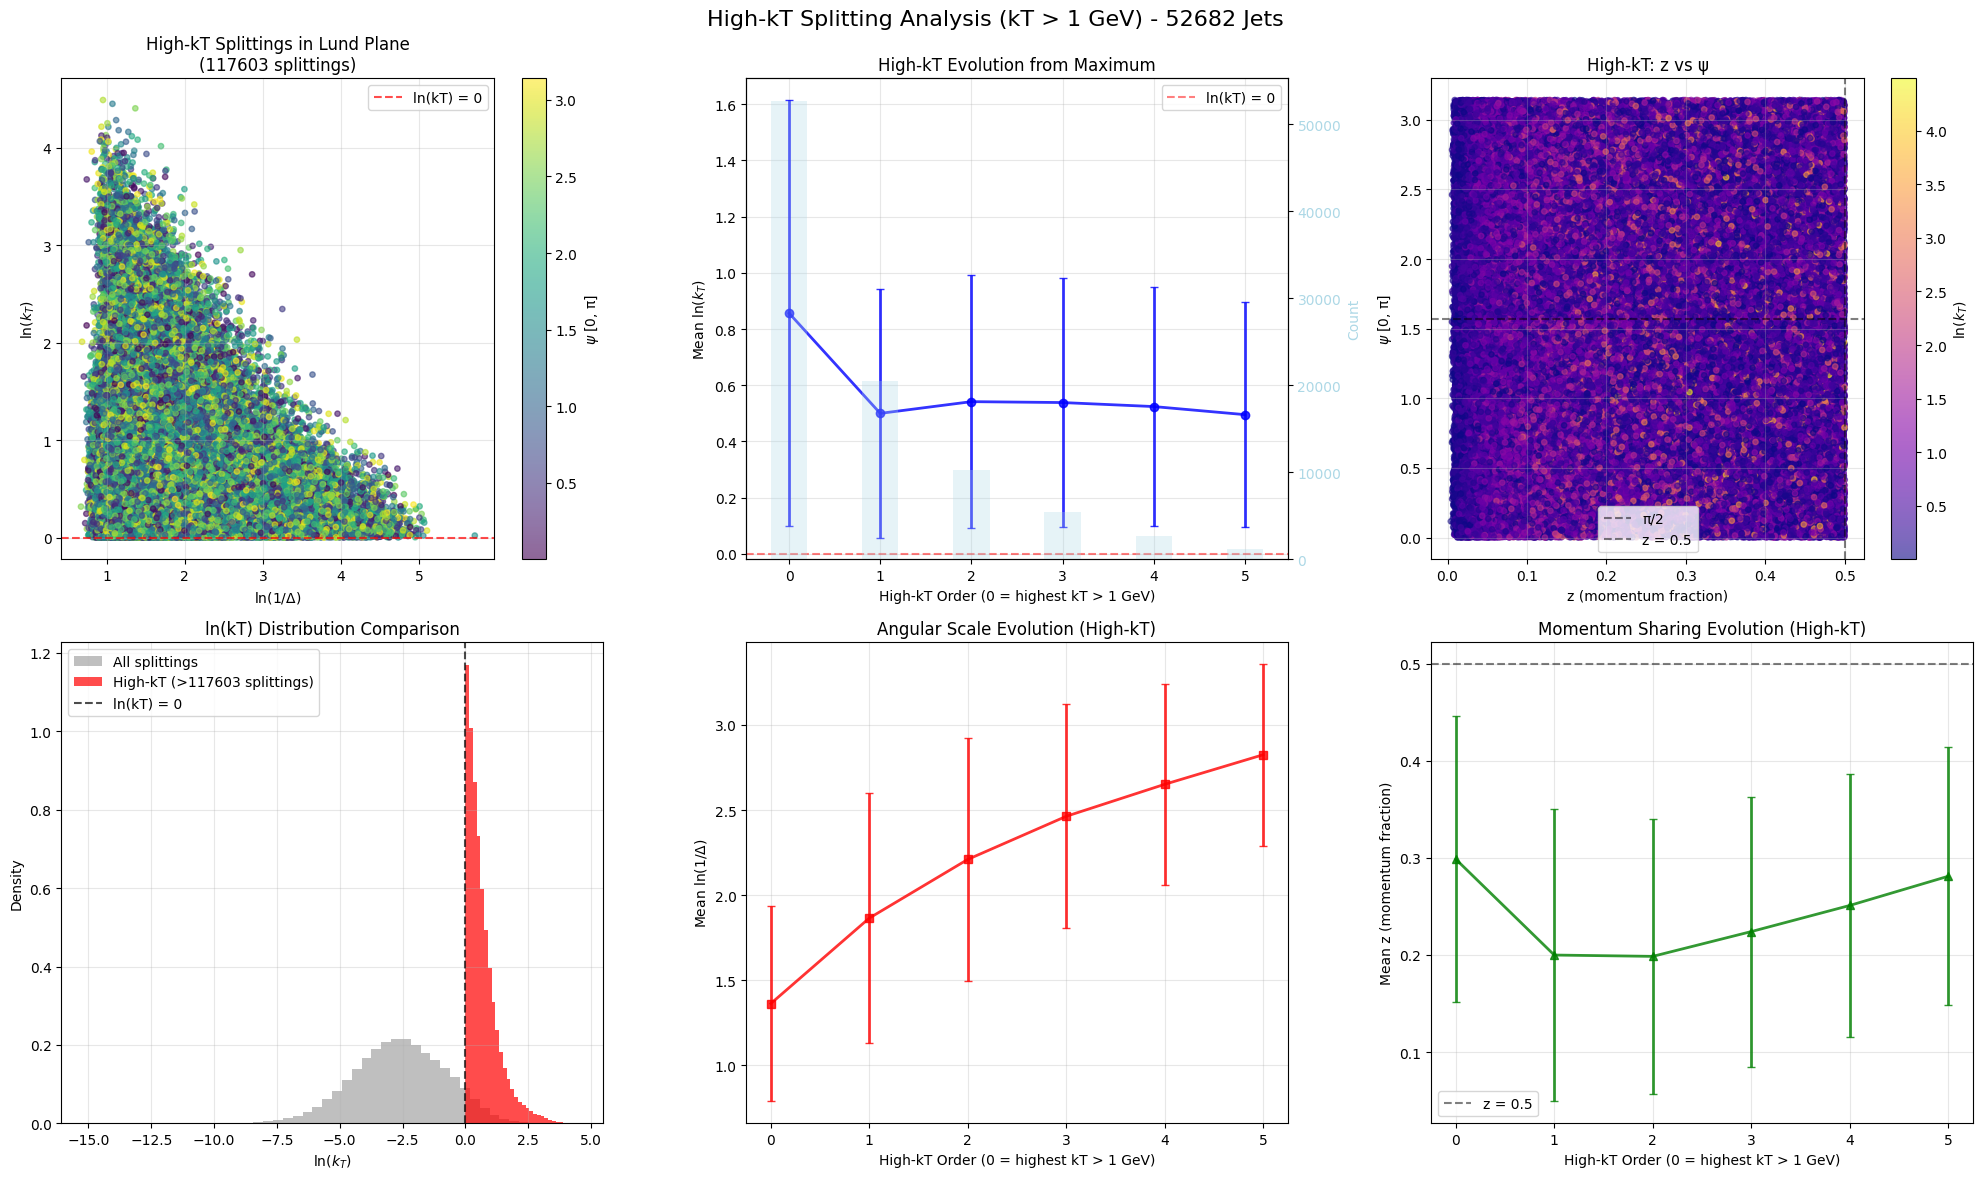


=== DETAILED HIGH-kT STATISTICS ===

Inclusive High-kT Properties:
  kT range: 1.00 - 89.20 GeV
  ln(1/Δ) range: 0.67 - 5.72
  z range: 0.004 - 0.500
  ψ range: 0.000 - 3.142

High-kT Order Evolution:
  Highest: N=52682, <ln(kT)>= 0.86±0.76, <ln(1/Δ)>= 1.36±0.58, <z>=0.299±0.147
  High+1: N=20462, <ln(kT)>= 0.50±0.44, <ln(1/Δ)>= 1.86±0.73, <z>=0.200±0.151
  High+2: N=10309, <ln(kT)>= 0.54±0.45, <ln(1/Δ)>= 2.21±0.71, <z>=0.199±0.141
  High+3: N=5449, <ln(kT)>= 0.54±0.44, <ln(1/Δ)>= 2.46±0.66, <z>=0.224±0.139
  High+4: N=2648, <ln(kT)>= 0.52±0.43, <ln(1/Δ)>= 2.65±0.59, <z>=0.251±0.136
  High+5: N=1158, <ln(kT)>= 0.50±0.40, <ln(1/Δ)>= 2.82±0.53, <z>=0.281±0.133

High-kT Evolution Trends:
  ln(kT) slope: -0.050 per order
  ln(1/Δ) slope: 0.284 per order
  z slope: 0.0026 per order

Comparison with All Splittings:
  High-kT fraction: 7.2%
  Jets with high-kT: 52682 / 869051 (6.1%)

Comparison with All Splittings:
  High-kT fraction: 7.2%
  Jets with high-kT: 52682 / 869051 (6.1%)


In [24]:
# Comprehensive visualization of high-kT splittings
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1) Inclusive high-kT distribution in Lund plane
ax1 = axes[0, 0]
scatter = ax1.scatter(df_high_kt_inclusive['ln_inv_delta'], df_high_kt_inclusive['ln_kt'], 
                     c=df_high_kt_inclusive['psi'], cmap='viridis', s=15, alpha=0.6)
plt.colorbar(scatter, ax=ax1, label=r'$\psi$ [0, π]')
ax1.set_xlabel(r'$\ln(1/\Delta)$')
ax1.set_ylabel(r'$\ln(k_T)$')
ax1.set_title(f'High-kT Splittings in Lund Plane\n({len(df_high_kt_inclusive)} splittings)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='ln(kT) = 0')
ax1.legend()

# 2) High-kT order evolution (if we have enough data)
if len(df_high_kt_order_stats) > 1:
    ax2 = axes[0, 1]
    ax2.errorbar(df_high_kt_order_stats['high_kt_order'], df_high_kt_order_stats['mean_ln_kt'], 
                 yerr=df_high_kt_order_stats['std_ln_kt'], 
                 marker='o', capsize=3, color='blue', alpha=0.8, linewidth=2)
    ax2.set_xlabel('High-kT Order (0 = highest kT > 1 GeV)')
    ax2.set_ylabel(r'Mean $\ln(k_T)$')
    ax2.set_title('High-kT Evolution from Maximum')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='ln(kT) = 0')
    ax2.legend()
    
    # Add count information
    ax2_twin = ax2.twinx()
    ax2_twin.bar(df_high_kt_order_stats['high_kt_order'], df_high_kt_order_stats['count'], 
                 alpha=0.3, color='lightblue', width=0.4)
    ax2_twin.set_ylabel('Count', color='lightblue')
    ax2_twin.tick_params(axis='y', labelcolor='lightblue')
else:
    ax2 = axes[0, 1]
    ax2.text(0.5, 0.5, 'Insufficient data\nfor order evolution', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('High-kT Order Evolution')

# 3) z vs ψ for high-kT splittings
ax3 = axes[0, 2]
scatter = ax3.scatter(df_high_kt_inclusive['z'], df_high_kt_inclusive['psi'], 
                     c=df_high_kt_inclusive['ln_kt'], cmap='plasma', s=15, alpha=0.6)
plt.colorbar(scatter, ax=ax3, label=r'$\ln(k_T)$')
ax3.set_xlabel('z (momentum fraction)')
ax3.set_ylabel(r'$\psi$ [0, π]')
ax3.set_title('High-kT: z vs ψ')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.5, label='π/2')
ax3.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='z = 0.5')
ax3.legend()

# 4) Distribution comparisons
ax4 = axes[1, 0]
# All splittings vs high-kT splittings
all_ln_kt = []
for _, row in df_jets.iterrows():
    for splitting in row['lunds']:
        all_ln_kt.append(np.log(splitting['kt']))

ax4.hist(all_ln_kt, bins=50, alpha=0.5, density=True, label='All splittings', color='gray')
ax4.hist(df_high_kt_inclusive['ln_kt'], bins=30, alpha=0.7, density=True, 
         label=f'High-kT (>{len(df_high_kt_inclusive)} splittings)', color='red')
ax4.axvline(x=0, color='black', linestyle='--', alpha=0.7, label='ln(kT) = 0')
ax4.set_xlabel(r'$\ln(k_T)$')
ax4.set_ylabel('Density')
ax4.set_title('ln(kT) Distribution Comparison')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5) Angular scale evolution for high-kT
if len(df_high_kt_order_stats) > 1:
    ax5 = axes[1, 1]
    ax5.errorbar(df_high_kt_order_stats['high_kt_order'], df_high_kt_order_stats['mean_ln_inv_delta'], 
                 yerr=df_high_kt_order_stats['std_ln_inv_delta'], 
                 marker='s', capsize=3, color='red', alpha=0.8, linewidth=2)
    ax5.set_xlabel('High-kT Order (0 = highest kT > 1 GeV)')
    ax5.set_ylabel(r'Mean $\ln(1/\Delta)$')
    ax5.set_title('Angular Scale Evolution (High-kT)')
    ax5.grid(True, alpha=0.3)
else:
    ax5 = axes[1, 1]
    ax5.text(0.5, 0.5, 'Insufficient data\nfor angular evolution', 
             ha='center', va='center', transform=ax5.transAxes, fontsize=12)
    ax5.set_title('Angular Scale Evolution')

# 6) Momentum sharing evolution for high-kT
if len(df_high_kt_order_stats) > 1:
    ax6 = axes[1, 2]
    ax6.errorbar(df_high_kt_order_stats['high_kt_order'], df_high_kt_order_stats['mean_z'], 
                 yerr=df_high_kt_order_stats['std_z'], 
                 marker='^', capsize=3, color='green', alpha=0.8, linewidth=2)
    ax6.set_xlabel('High-kT Order (0 = highest kT > 1 GeV)')
    ax6.set_ylabel('Mean z (momentum fraction)')
    ax6.set_title('Momentum Sharing Evolution (High-kT)')
    ax6.grid(True, alpha=0.3)
    ax6.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='z = 0.5')
    ax6.legend()
else:
    ax6 = axes[1, 2]
    ax6.text(0.5, 0.5, 'Insufficient data\nfor z evolution', 
             ha='center', va='center', transform=ax6.transAxes, fontsize=12)
    ax6.set_title('Momentum Sharing Evolution')

plt.suptitle(f'High-kT Splitting Analysis (kT > 1 GeV) - {jets_with_high_kt} Jets', fontsize=16)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n=== DETAILED HIGH-kT STATISTICS ===")

print("\nInclusive High-kT Properties:")
print(f"  kT range: {df_high_kt_inclusive['kt'].min():.2f} - {df_high_kt_inclusive['kt'].max():.2f} GeV")
print(f"  ln(1/Δ) range: {df_high_kt_inclusive['ln_inv_delta'].min():.2f} - {df_high_kt_inclusive['ln_inv_delta'].max():.2f}")
print(f"  z range: {df_high_kt_inclusive['z'].min():.3f} - {df_high_kt_inclusive['z'].max():.3f}")
print(f"  ψ range: {df_high_kt_inclusive['psi'].min():.3f} - {df_high_kt_inclusive['psi'].max():.3f}")

if len(df_high_kt_order_stats) > 1:
    print("\nHigh-kT Order Evolution:")
    for _, row in df_high_kt_order_stats.iterrows():
        order = int(row['high_kt_order'])
        order_label = "Highest" if order == 0 else f"High+{order}"
        print(f"  {order_label}: N={int(row['count']):>4d}, "
              f"<ln(kT)>={row['mean_ln_kt']:>5.2f}±{row['std_ln_kt']:.2f}, "
              f"<ln(1/Δ)>={row['mean_ln_inv_delta']:>5.2f}±{row['std_ln_inv_delta']:.2f}, "
              f"<z>={row['mean_z']:>5.3f}±{row['std_z']:.3f}")
    
    # Calculate trends if we have enough points
    if len(df_high_kt_order_stats) > 2:
        print("\nHigh-kT Evolution Trends:")
        orders = df_high_kt_order_stats['high_kt_order'].values
        
        kt_slope = np.polyfit(orders, df_high_kt_order_stats['mean_ln_kt'], 1)[0]
        print(f"  ln(kT) slope: {kt_slope:.3f} per order")
        
        delta_slope = np.polyfit(orders, df_high_kt_order_stats['mean_ln_inv_delta'], 1)[0]
        print(f"  ln(1/Δ) slope: {delta_slope:.3f} per order")
        
        z_slope = np.polyfit(orders, df_high_kt_order_stats['mean_z'], 1)[0]
        print(f"  z slope: {z_slope:.4f} per order")
else:
    print("\nInsufficient data for order-by-order evolution analysis")
    print("(Most jets have only one high-kT splitting)")

# Comparison with all splittings
all_splittings_count = sum(len(row['lunds']) for _, row in df_jets.iterrows())
print(f"\nComparison with All Splittings:")
print(f"  High-kT fraction: {len(df_high_kt_inclusive) / all_splittings_count:.1%}")
print(f"  Jets with high-kT: {jets_with_high_kt} / {len(df_jets)} ({jets_with_high_kt/len(df_jets):.1%})")

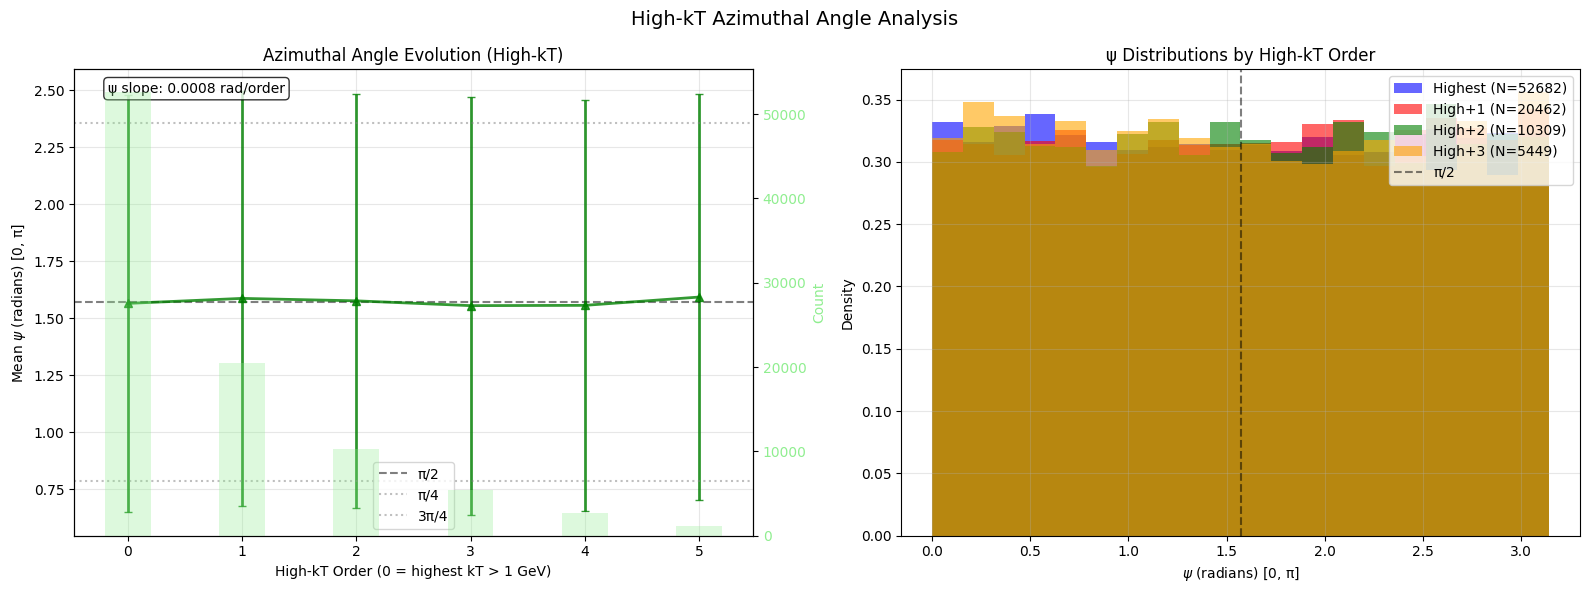


=== HIGH-kT PSI ANGLE ANALYSIS ===

Inclusive High-kT Psi Statistics:
  Mean ψ: 1.570 ± 0.914 rad
  Mean ψ: 90.0 ± 52.4°
  Median ψ: 1.570 rad (89.9°)
  Fraction with ψ < π/4: 0.255
  Fraction with π/4 < ψ < 3π/4: 0.491
  Fraction with ψ > 3π/4: 0.254

Psi Evolution by High-kT Order:
  Highest: <ψ> = 1.565 ± 0.914 rad (89.7° ± 52.4°)
  High+1: <ψ> = 1.587 ± 0.911 rad (90.9° ± 52.2°)
  High+2: <ψ> = 1.576 ± 0.908 rad (90.3° ± 52.0°)
  High+3: <ψ> = 1.555 ± 0.915 rad (89.1° ± 52.4°)
  High+4: <ψ> = 1.557 ± 0.899 rad (89.2° ± 51.5°)
  High+5: <ψ> = 1.593 ± 0.889 rad (91.3° ± 50.9°)

Psi Evolution Trend:
  Slope: 0.0008 rad per order (0.04° per order)
  → ψ increases with splitting order (more perpendicular branching)

Comparison with Random Expectations:
  Expected (uniform): 1.571 rad (90.0°)
  Observed: 1.570 rad (90.0°)
  Difference: -0.001 rad (-0.0°)
  → High-kT splittings show approximately random angular distribution


In [26]:
# Additional analysis: Mean psi evolution for high-kT splittings
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) Mean psi vs high-kT splitting order (if we have sufficient data)
if len(df_high_kt_order_stats) > 1:
    ax1 = axes[0]
    ax1.errorbar(df_high_kt_order_stats['high_kt_order'], df_high_kt_order_stats['mean_psi'], 
                 yerr=df_high_kt_order_stats['std_psi'], 
                 marker='^', capsize=3, color='green', alpha=0.8, linewidth=2)
    ax1.set_xlabel('High-kT Order (0 = highest kT > 1 GeV)')
    ax1.set_ylabel(r'Mean $\psi$ (radians) [0, π]')
    ax1.set_title('Azimuthal Angle Evolution (High-kT)')
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=np.pi/2, color='black', linestyle='--', alpha=0.5, label='π/2')
    ax1.axhline(y=np.pi/4, color='gray', linestyle=':', alpha=0.5, label='π/4')
    ax1.axhline(y=3*np.pi/4, color='gray', linestyle=':', alpha=0.5, label='3π/4')
    ax1.legend()
    
    # Add count information as secondary y-axis
    ax1_twin = ax1.twinx()
    ax1_twin.bar(df_high_kt_order_stats['high_kt_order'], df_high_kt_order_stats['count'], 
                 alpha=0.3, color='lightgreen', width=0.4)
    ax1_twin.set_ylabel('Count', color='lightgreen')
    ax1_twin.tick_params(axis='y', labelcolor='lightgreen')
    
    # Calculate psi trend
    if len(df_high_kt_order_stats) > 2:
        orders = df_high_kt_order_stats['high_kt_order'].values
        psi_slope = np.polyfit(orders, df_high_kt_order_stats['mean_psi'], 1)[0]
        ax1.text(0.05, 0.95, f'ψ slope: {psi_slope:.4f} rad/order', 
                transform=ax1.transAxes, fontsize=10, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax1 = axes[0]
    ax1.text(0.5, 0.5, 'Insufficient data\nfor psi evolution\n(Need multiple high-kT orders)', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Mean ψ vs High-kT Order')
    ax1.set_xlabel('High-kT Order')
    ax1.set_ylabel(r'Mean $\psi$ (radians)')

# 2) Psi distribution for different high-kT orders (if we have data)
ax2 = axes[1]
if len(df_high_kt_order_stats) > 1 and len(df_high_kt_from_max) > 0:
    # Plot psi distributions for first few orders
    max_orders_to_plot = min(4, df_high_kt_from_max['high_kt_order'].max() + 1)
    colors = ['blue', 'red', 'green', 'orange']
    
    for order in range(max_orders_to_plot):
        order_data = df_high_kt_from_max[df_high_kt_from_max['high_kt_order'] == order]
        if len(order_data) > 5:  # Only plot if we have enough data
            order_label = "Highest" if order == 0 else f"High+{order}"
            ax2.hist(order_data['psi'], bins=20, alpha=0.6, density=True, 
                    label=f'{order_label} (N={len(order_data)})', 
                    color=colors[order % len(colors)])
    
    ax2.axvline(x=np.pi/2, color='black', linestyle='--', alpha=0.5, label='π/2')
    ax2.set_xlabel(r'$\psi$ (radians) [0, π]')
    ax2.set_ylabel('Density')
    ax2.set_title('ψ Distributions by High-kT Order')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
else:
    # Show overall high-kT psi distribution
    if len(df_high_kt_inclusive) > 0:
        ax2.hist(df_high_kt_inclusive['psi'], bins=30, alpha=0.7, density=True, 
                color='blue', label=f'All High-kT (N={len(df_high_kt_inclusive)})')
        ax2.axvline(x=np.pi/2, color='black', linestyle='--', alpha=0.5, label='π/2')
        ax2.set_xlabel(r'$\psi$ (radians) [0, π]')
        ax2.set_ylabel('Density')
        ax2.set_title('ψ Distribution (All High-kT)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No high-kT data\navailable', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('ψ Distribution')

plt.suptitle('High-kT Azimuthal Angle Analysis', fontsize=14)
plt.tight_layout()
plt.show()

# Print psi-specific statistics
print("\n=== HIGH-kT PSI ANGLE ANALYSIS ===")

if len(df_high_kt_inclusive) > 0:
    print("\nInclusive High-kT Psi Statistics:")
    print(f"  Mean ψ: {df_high_kt_inclusive['psi'].mean():.3f} ± {df_high_kt_inclusive['psi'].std():.3f} rad")
    print(f"  Mean ψ: {np.degrees(df_high_kt_inclusive['psi'].mean()):.1f} ± {np.degrees(df_high_kt_inclusive['psi'].std()):.1f}°")
    print(f"  Median ψ: {df_high_kt_inclusive['psi'].median():.3f} rad ({np.degrees(df_high_kt_inclusive['psi'].median()):.1f}°)")
    
    # Fraction in different angular ranges
    print(f"  Fraction with ψ < π/4: {(df_high_kt_inclusive['psi'] < np.pi/4).mean():.3f}")
    print(f"  Fraction with π/4 < ψ < 3π/4: {((df_high_kt_inclusive['psi'] > np.pi/4) & (df_high_kt_inclusive['psi'] < 3*np.pi/4)).mean():.3f}")
    print(f"  Fraction with ψ > 3π/4: {(df_high_kt_inclusive['psi'] > 3*np.pi/4).mean():.3f}")

if len(df_high_kt_order_stats) > 1:
    print("\nPsi Evolution by High-kT Order:")
    for _, row in df_high_kt_order_stats.iterrows():
        order = int(row['high_kt_order'])
        order_label = "Highest" if order == 0 else f"High+{order}"
        print(f"  {order_label}: <ψ> = {row['mean_psi']:.3f} ± {row['std_psi']:.3f} rad "
              f"({np.degrees(row['mean_psi']):.1f}° ± {np.degrees(row['std_psi']):.1f}°)")
    
    # Psi trend analysis
    if len(df_high_kt_order_stats) > 2:
        orders = df_high_kt_order_stats['high_kt_order'].values
        psi_slope = np.polyfit(orders, df_high_kt_order_stats['mean_psi'], 1)[0]
        print(f"\nPsi Evolution Trend:")
        print(f"  Slope: {psi_slope:.4f} rad per order ({np.degrees(psi_slope):.2f}° per order)")
        if psi_slope > 0:
            print(f"  → ψ increases with splitting order (more perpendicular branching)")
        elif psi_slope < 0:
            print(f"  → ψ decreases with splitting order (more aligned branching)")
        else:
            print(f"  → ψ remains approximately constant")
else:
    print("\nInsufficient data for order-by-order psi evolution analysis")

# Compare with theoretical expectations
if len(df_high_kt_inclusive) > 0:
    print(f"\nComparison with Random Expectations:")
    # For uniform distribution in [0, π], mean would be π/2 ≈ 1.571
    expected_mean = np.pi / 2
    observed_mean = df_high_kt_inclusive['psi'].mean()
    print(f"  Expected (uniform): {expected_mean:.3f} rad ({np.degrees(expected_mean):.1f}°)")
    print(f"  Observed: {observed_mean:.3f} rad ({np.degrees(observed_mean):.1f}°)")
    print(f"  Difference: {observed_mean - expected_mean:.3f} rad ({np.degrees(observed_mean - expected_mean):.1f}°)")
    
    if abs(observed_mean - expected_mean) > 0.1:  # More than ~6 degrees difference
        if observed_mean < expected_mean:
            print(f"  → High-kT splittings prefer more aligned configurations")
        else:
            print(f"  → High-kT splittings prefer more perpendicular configurations")
    else:
        print(f"  → High-kT splittings show approximately random angular distribution")